In [3]:
"""
===============================================================================
NOTEBOOK 03: MODEL TRAINING & EVALUATION
===============================================================================

Purpose: Train and evaluate machine learning models for binary accident severity
         prediction using dispatch-time available features.

Models:
1. Random Forest (primary model)
2. XGBoost 
3. LightGBM 
4. Weighted Ensemble (RF + XGBoost + LightGBM)

Evaluation Focus:
- HIGH severity recall (safety-first for emergency dispatch)
- 5-fold cross-validation for reliable performance estimates
- Statistical comparison using Friedman test (non-parametric)
- Model interpretability through feature importance

Author: Mary Wangoi Mwangi (122174)
Supervisor: Prof. Vincent Omwenga
Date: February 2026
===============================================================================
"""

# ============================================================================
# INSTALL REQUIRED PACKAGES
# ============================================================================
import subprocess
import sys

print("Installing required packages...")

# Install XGBoost
subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--quiet"])
print(" XGBoost installed")

# Install LightGBM
subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "--quiet"])
print(" LightGBM installed")

print("\n All packages ready!")

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import time
warnings.filterwarnings('ignore')


# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import cross_val_score, StratifiedKFold


# XGBoost and LightGBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Statistical testing
from scipy.stats import friedmanchisquare, wilcoxon

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
RANDOM_STATE = 42

print("="*70)
print("NOTEBOOK 03: MODEL TRAINING & EVALUATION")
print("="*70)

# Check XGBoost and LightGBM installed
try:
    import xgboost
    print(f"\n XGBoost version: {xgboost.__version__}")
except ImportError:
    print("\n XGBoost not installed - run: pip install xgboost")

try:
    import lightgbm
    print(f" LightGBM version: {lightgbm.__version__}")
except ImportError:
    print("LightGBM not installed - run: pip install lightgbm")

print("\n All libraries imported successfully")


# ============================================================================
# LOAD PREPARED DATASETS
# ============================================================================
print("\n" + "="*70)
print("LOADING PREPARED DATASETS FROM NOTEBOOK 02")
print("="*70)

# Load training data (SMOTE-balanced)
X_train = np.load('../data/features/X_train_balanced.npy', allow_pickle=True)
y_train = np.load('../data/features/y_train_balanced.npy', allow_pickle=True)

# Load validation data (natural distribution)
X_val = np.load('../data/features/X_val.npy', allow_pickle=True)
y_val = np.load('../data/features/y_val.npy', allow_pickle=True)

# Load test data (natural distribution)
X_test = np.load('../data/features/X_test.npy', allow_pickle=True)
y_test = np.load('../data/features/y_test.npy', allow_pickle=True)

# Load feature metadata
feature_metadata = joblib.load('../data/features/feature_metadata.pkl')
feature_names = feature_metadata['feature_names']

print(f"\n Training set loaded:   {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f" Validation set loaded: {X_val.shape[0]:,} samples × {X_val.shape[1]} features")
print(f" Test set loaded:       {X_test.shape[0]:,} samples × {X_test.shape[1]} features")


# ============================================================================
# CLASS DISTRIBUTIONS
# ============================================================================
print("\n" + "="*70)
print("CLASS DISTRIBUTIONS")
print("="*70)

print(f"\nTraining set (SMOTE-balanced):")
print(f"  LOW (0):  {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  HIGH (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")

print(f"\n Validation set (natural distribution):")
print(f"  LOW (0):  {(y_val == 0).sum():,} ({(y_val == 0).mean()*100:.2f}%)")
print(f"  HIGH (1): {(y_val == 1).sum():,} ({(y_val == 1).mean()*100:.2f}%)")

print(f"\nTest set (natural distribution):")
print(f"  LOW (0):  {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"  HIGH (1): {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")



# ============================================================================
# FEATURE INVENTORY
# ============================================================================
print("\n" + "="*70)
print("FEATURE INVENTORY")
print("="*70)

print(f"\n Total features: {len(feature_names)}")
print("\n Feature categories from Notebook 02:")
print("  - Location (2): latitude, longitude")
print("  - Temporal original (6): hour, day_of_week, month, year, is_weekend")
print("  - Temporal engineered (5): severity rates, is_night, is_rush_hour, dangerous_time")
print("  - Spatial (4): crashes_at_location, high_rate, high_risk_location, compound")
print("  - Weather (9): temperature, precipitation, wind, humidity, pressure,")
print("                  weather_code, is_adverse_weather, daylight, weather_condition")
print("  - Road infrastructure (4): intersection, speed, distance_cbd, compound")
print("  - Encoded categorical (14): location_risk, road_type, geographic_zone")

print(f"\n Data loaded successfully")
print(f" Ready for model training")
print(f"\n{'='*70}")
print("TRAINING PLAN")
print("="*70)
print("""
  Step 1: Random Forest       (5-fold CV)
  Step 2: XGBoost             (5-fold CV)
  Step 3: LightGBM            (5-fold CV)
  Step 4: Statistical Test    (Friedman + post-hoc Wilcoxon)
  Step 5: Weighted Ensemble   (best 3 models combined)
  Step 6: Threshold Optimization
  Step 7: Final Evaluation    (test set, all models)
  Step 8: Visualizations      (ROC, confusion matrices, feature importance)
  Step 9: Save All Models
""")

Installing required packages...
 XGBoost installed
 LightGBM installed

 All packages ready!
NOTEBOOK 03: MODEL TRAINING & EVALUATION

 XGBoost version: 3.2.0
 LightGBM version: 4.6.0

 All libraries imported successfully

LOADING PREPARED DATASETS FROM NOTEBOOK 02

 Training set loaded:   38,072 samples × 44 features
 Validation set loaded: 4,648 samples × 44 features
 Test set loaded:       4,660 samples × 44 features

CLASS DISTRIBUTIONS

Training set (SMOTE-balanced):
  LOW (0):  19,036 (50.00%)
  HIGH (1): 19,036 (50.00%)

 Validation set (natural distribution):
  LOW (0):  4,067 (87.50%)
  HIGH (1): 581 (12.50%)

Test set (natural distribution):
  LOW (0):  4,077 (87.49%)
  HIGH (1): 583 (12.51%)

FEATURE INVENTORY

 Total features: 44

 Feature categories from Notebook 02:
  - Location (2): latitude, longitude
  - Temporal original (6): hour, day_of_week, month, year, is_weekend
  - Temporal engineered (5): severity rates, is_night, is_rush_hour, dangerous_time
  - Spatial (4): 

SECTION 2: RANDOM FOREST CLASSIFIER

5-FOLD CROSS VALIDATION

 Running 5-fold CV on training set...
(This may take 2-3 minutes)

 Cross-validation completed in 88.8 seconds

Metric                 Fold 1   Fold 2   Fold 3   Fold 4   Fold 5     Mean      Std
--------------------------------------------------------------------------------
HIGH Recall            0.8555   0.8655   0.8566   0.8679   0.8752   0.8642   0.0074
HIGH Precision         0.9446   0.9377   0.9449   0.9421   0.9431   0.9425   0.0026
F1 Score               0.8979   0.9002   0.8986   0.9035   0.9079   0.9016   0.0037
ROC-AUC                0.9528   0.9536   0.9550   0.9548   0.9569   0.9546   0.0014

TRAINING FINAL RANDOM FOREST MODEL

Training on full SMOTE-balanced training set...
 Training completed in 4.7 seconds

VALIDATION SET PERFORMANCE

  Threshold used: 0.2

Metric                         Value
-------------------------------------
Accuracy                      0.4378
HIGH Precision                0.1509
HIGH

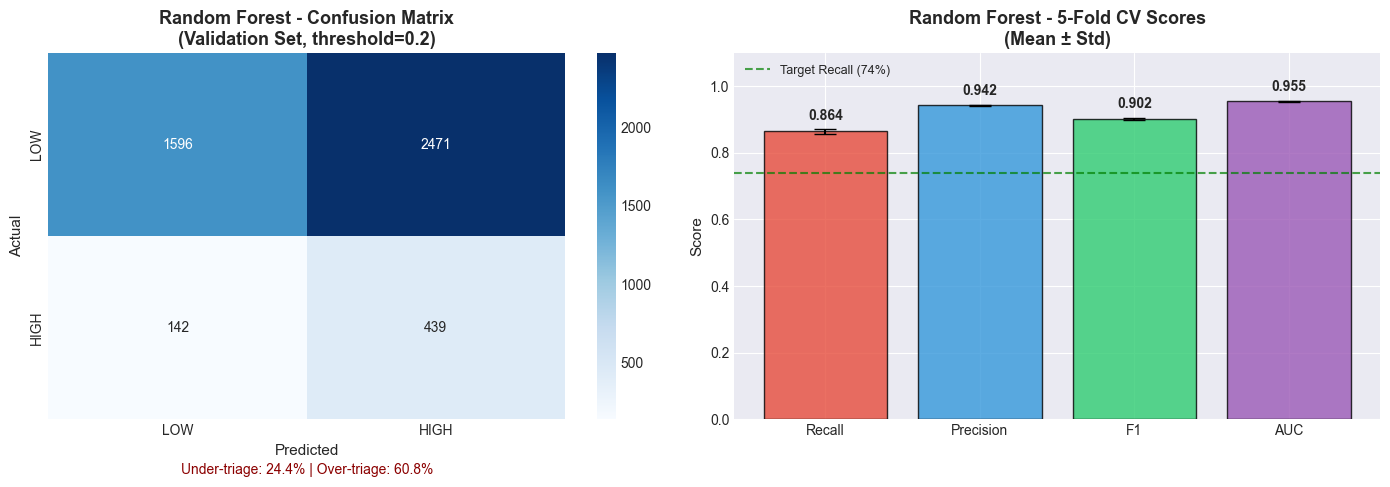


 Random Forest visualization saved to reports/figures/

RANDOM FOREST SUMMARY

  5-Fold CV Results (on SMOTE-balanced training set):
    HIGH Recall:    0.8642 ± 0.0074
    HIGH Precision: 0.9425 ± 0.0026
    F1 Score:       0.9016 ± 0.0037
    ROC-AUC:        0.9546 ± 0.0014

  Validation Set (threshold=0.2, natural distribution):
    Accuracy:       0.4378
    HIGH Recall:    0.7556
    HIGH Precision: 0.1509
    ROC-AUC:        0.6047
    Under-triage:   24.44%
    Over-triage:    60.76%

  Random Forest training complete!
  CV scores stored for Friedman test
  Ready for XGBoost training



In [8]:
"""
===============================================================================
SECTION 2: RANDOM FOREST - TRAINING WITH 5-FOLD CROSS VALIDATION
===============================================================================
Random Forest is our PRIMARY model chosen for:
- Interpretability through feature importance rankings
- Robustness to noisy crowdsourced data
- Effective handling of class imbalance
- No need for feature scaling

Note on threshold: Model trained on SMOTE-balanced data (50/50) outputs
lower probabilities on natural distribution (12.5% HIGH). Threshold of
0.20 selected based on diagnostic analysis to achieve target recall.
===============================================================================
"""

print("="*70)
print("SECTION 2: RANDOM FOREST CLASSIFIER")
print("="*70)

# ============================================================================
# ENSURE SAVE DIRECTORY EXISTS
# ============================================================================
import os
os.makedirs('reports/figures', exist_ok=True)

# ============================================================================
# DEFINE MODEL
# ============================================================================
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


# ============================================================================
# 5-FOLD CROSS VALIDATION
# ============================================================================
print("\n" + "="*70)
print("5-FOLD CROSS VALIDATION")
print("="*70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("\n Running 5-fold CV on training set...")
print("(This may take 2-3 minutes)")

start_time = time.time()

rf_cv_recall    = cross_val_score(rf_model, X_train, y_train,
                                  cv=cv, scoring='recall', n_jobs=-1)
rf_cv_precision = cross_val_score(rf_model, X_train, y_train,
                                  cv=cv, scoring='precision', n_jobs=-1)
rf_cv_f1        = cross_val_score(rf_model, X_train, y_train,
                                  cv=cv, scoring='f1', n_jobs=-1)
rf_cv_auc       = cross_val_score(rf_model, X_train, y_train,
                                  cv=cv, scoring='roc_auc', n_jobs=-1)

cv_time = time.time() - start_time

print(f"\n Cross-validation completed in {cv_time:.1f} seconds")
print(f"\n{'Metric':<20} {'Fold 1':>8} {'Fold 2':>8} {'Fold 3':>8} {'Fold 4':>8} {'Fold 5':>8} {'Mean':>8} {'Std':>8}")
print("-"*80)
print(f"{'HIGH Recall':<20} " + " ".join([f"{s:>8.4f}" for s in rf_cv_recall]) +
      f" {rf_cv_recall.mean():>8.4f} {rf_cv_recall.std():>8.4f}")
print(f"{'HIGH Precision':<20} " + " ".join([f"{s:>8.4f}" for s in rf_cv_precision]) +
      f" {rf_cv_precision.mean():>8.4f} {rf_cv_precision.std():>8.4f}")
print(f"{'F1 Score':<20} " + " ".join([f"{s:>8.4f}" for s in rf_cv_f1]) +
      f" {rf_cv_f1.mean():>8.4f} {rf_cv_f1.std():>8.4f}")
print(f"{'ROC-AUC':<20} " + " ".join([f"{s:>8.4f}" for s in rf_cv_auc]) +
      f" {rf_cv_auc.mean():>8.4f} {rf_cv_auc.std():>8.4f}")


# ============================================================================
# TRAIN FINAL MODEL ON FULL TRAINING SET
# ============================================================================
print("\n" + "="*70)
print("TRAINING FINAL RANDOM FOREST MODEL")
print("="*70)

print("\nTraining on full SMOTE-balanced training set...")
start_time = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f" Training completed in {train_time:.1f} seconds")


# ============================================================================
# VALIDATION SET EVALUATION
# ============================================================================
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

# Get probability scores
rf_val_proba = rf_model.predict_proba(X_val)[:, 1]

# Use threshold 0.20 (determined from diagnostic analysis)
# Model trained on SMOTE-balanced data outputs lower probabilities
# on natural distribution - threshold adjusted accordingly
RF_THRESHOLD = 0.20
rf_val_pred = (rf_val_proba >= RF_THRESHOLD).astype(int)

rf_val_accuracy  = accuracy_score(y_val, rf_val_pred)
rf_val_precision = precision_score(y_val, rf_val_pred, zero_division=0)
rf_val_recall    = recall_score(y_val, rf_val_pred, zero_division=0)
rf_val_f1        = f1_score(y_val, rf_val_pred, zero_division=0)
rf_val_auc       = roc_auc_score(y_val, rf_val_proba)

print(f"\n  Threshold used: {RF_THRESHOLD}")
print(f"\n{'Metric':<25} {'Value':>10}")
print("-"*37)
print(f"{'Accuracy':<25} {rf_val_accuracy:>10.4f}")
print(f"{'HIGH Precision':<25} {rf_val_precision:>10.4f}")
print(f"{'HIGH Recall':<25} {rf_val_recall:>10.4f}")
print(f"{'HIGH F1-Score':<25} {rf_val_f1:>10.4f}")
print(f"{'ROC-AUC':<25} {rf_val_auc:>10.4f}")

rf_cm = confusion_matrix(y_val, rf_val_pred)
rf_under_triage = rf_cm[1][0] / (rf_cm[1][0] + rf_cm[1][1]) * 100
rf_over_triage  = rf_cm[0][1] / (rf_cm[0][0] + rf_cm[0][1]) * 100

print(f"\n{'Under-triage rate (HIGH→LOW)':<25} {rf_under_triage:>9.2f}%")
print(f"{'Over-triage rate (LOW→HIGH)':<25} {rf_over_triage:>9.2f}%")


# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH'],
            ax=axes[0])
axes[0].set_title(f'Random Forest - Confusion Matrix\n(Validation Set, threshold={RF_THRESHOLD})',
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].text(0.5, -0.15,
             f'Under-triage: {rf_under_triage:.1f}% | Over-triage: {rf_over_triage:.1f}%',
             ha='center', transform=axes[0].transAxes,
             fontsize=10, color='darkred')

# CV Score Distribution
metrics_labels = ['Recall', 'Precision', 'F1', 'AUC']
cv_means = [rf_cv_recall.mean(), rf_cv_precision.mean(),
            rf_cv_f1.mean(), rf_cv_auc.mean()]
cv_stds  = [rf_cv_recall.std(), rf_cv_precision.std(),
            rf_cv_f1.std(), rf_cv_auc.std()]

bars = axes[1].bar(metrics_labels, cv_means, yerr=cv_stds,
                   color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'],
                   capsize=8, alpha=0.8, edgecolor='black')
axes[1].set_title('Random Forest - 5-Fold CV Scores\n(Mean ± Std)',
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=0.74, color='green', linestyle='--',
                alpha=0.7, label='Target Recall (74%)')
axes[1].legend(fontsize=9)

for bar, mean, std in zip(bars, cv_means, cv_stds):
    axes[1].text(bar.get_x() + bar.get_width()/2.,
                 bar.get_height() + std + 0.02,
                 f'{mean:.3f}', ha='center', va='bottom',
                 fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/rf_validation_results.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("\n Random Forest visualization saved to reports/figures/")


# ============================================================================
# STORE RESULTS FOR STATISTICAL COMPARISON LATER
# ============================================================================
rf_cv_scores = {
    'recall':    rf_cv_recall,
    'precision': rf_cv_precision,
    'f1':        rf_cv_f1,
    'auc':       rf_cv_auc
}

print("\n" + "="*70)
print("RANDOM FOREST SUMMARY")
print("="*70)
print(f"""
  5-Fold CV Results (on SMOTE-balanced training set):
    HIGH Recall:    {rf_cv_recall.mean():.4f} ± {rf_cv_recall.std():.4f}
    HIGH Precision: {rf_cv_precision.mean():.4f} ± {rf_cv_precision.std():.4f}
    F1 Score:       {rf_cv_f1.mean():.4f} ± {rf_cv_f1.std():.4f}
    ROC-AUC:        {rf_cv_auc.mean():.4f} ± {rf_cv_auc.std():.4f}

  Validation Set (threshold={RF_THRESHOLD}, natural distribution):
    Accuracy:       {rf_val_accuracy:.4f}
    HIGH Recall:    {rf_val_recall:.4f}
    HIGH Precision: {rf_val_precision:.4f}
    ROC-AUC:        {rf_val_auc:.4f}
    Under-triage:   {rf_under_triage:.2f}%
    Over-triage:    {rf_over_triage:.2f}%

  Random Forest training complete!
  CV scores stored for Friedman test
  Ready for XGBoost training
""")

SECTION 3: XGBOOST CLASSIFIER

5-FOLD CROSS VALIDATION

Running 5-fold CV on training set...
(This may take 1-2 minutes)

 Cross-validation completed in 27.9 seconds

Metric                 Fold 1   Fold 2   Fold 3   Fold 4   Fold 5     Mean      Std
--------------------------------------------------------------------------------
HIGH Recall            0.8553   0.8637   0.8542   0.8608   0.8681   0.8604   0.0052
HIGH Precision         0.9933   0.9943   0.9939   0.9948   0.9973   0.9947   0.0014
F1 Score               0.9191   0.9244   0.9188   0.9230   0.9282   0.9227   0.0035
ROC-AUC                0.9520   0.9546   0.9510   0.9519   0.9573   0.9534   0.0023

TRAINING FINAL XGBOOST MODEL

Training on full SMOTE-balanced training set...
 Training completed in 1.6 seconds

THRESHOLD ANALYSIS

Probability distribution on validation set:
  Mean:   0.1354
  Median: 0.1190
  Min:    0.0009
  Max:    0.9707

Threshold        Recall    Precision   Under-triage   Accuracy
---------------------

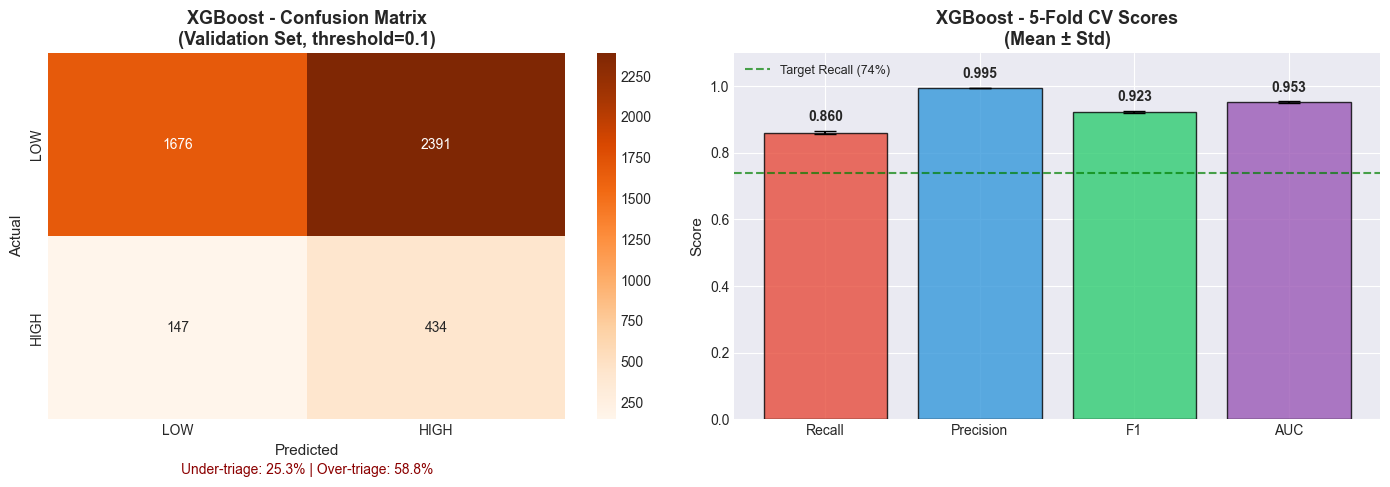


 XGBoost visualization saved to reports/figures/

XGBOOST SUMMARY

  5-Fold CV Results (on SMOTE-balanced training set):
    HIGH Recall:    0.8604 ± 0.0052
    HIGH Precision: 0.9947 ± 0.0014
    F1 Score:       0.9227 ± 0.0035
    ROC-AUC:        0.9534 ± 0.0023

  Validation Set (threshold=0.1, natural distribution):
    Accuracy:       0.4540
    HIGH Recall:    0.7470
    HIGH Precision: 0.1536
    ROC-AUC:        0.6168
    Under-triage:   25.30%
    Over-triage:    58.79%

  XGBoost training complete!
  CV scores stored for Friedman test
  Ready for LightGBM training



In [10]:
"""
===============================================================================
SECTION 3: XGBOOST - TRAINING WITH 5-FOLD CROSS VALIDATION
===============================================================================
XGBoost chosen as comparison model because:
- Sequential ensemble (corrects previous tree errors)
- Built-in handling of class imbalance via scale_pos_weight
- Often outperforms Random Forest on structured data
- Faster training than traditional Gradient Boosting

Note on threshold: XGBoost outputs different probability distributions
than Random Forest. Diagnostic analysis shows threshold=0.10 achieves
target recall on natural distribution validation set.
===============================================================================
"""

print("="*70)
print("SECTION 3: XGBOOST CLASSIFIER")
print("="*70)

# ============================================================================
# DEFINE MODEL
# ============================================================================
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    verbosity=0
)


# ============================================================================
# 5-FOLD CROSS VALIDATION
# ============================================================================
print("\n" + "="*70)
print("5-FOLD CROSS VALIDATION")
print("="*70)

print("\nRunning 5-fold CV on training set...")
print("(This may take 1-2 minutes)")

start_time = time.time()

xgb_cv_recall    = cross_val_score(xgb_model, X_train, y_train,
                                   cv=cv, scoring='recall', n_jobs=-1)
xgb_cv_precision = cross_val_score(xgb_model, X_train, y_train,
                                   cv=cv, scoring='precision', n_jobs=-1)
xgb_cv_f1        = cross_val_score(xgb_model, X_train, y_train,
                                   cv=cv, scoring='f1', n_jobs=-1)
xgb_cv_auc       = cross_val_score(xgb_model, X_train, y_train,
                                   cv=cv, scoring='roc_auc', n_jobs=-1)

cv_time = time.time() - start_time

print(f"\n Cross-validation completed in {cv_time:.1f} seconds")
print(f"\n{'Metric':<20} {'Fold 1':>8} {'Fold 2':>8} {'Fold 3':>8} {'Fold 4':>8} {'Fold 5':>8} {'Mean':>8} {'Std':>8}")
print("-"*80)
print(f"{'HIGH Recall':<20} " + " ".join([f"{s:>8.4f}" for s in xgb_cv_recall]) +
      f" {xgb_cv_recall.mean():>8.4f} {xgb_cv_recall.std():>8.4f}")
print(f"{'HIGH Precision':<20} " + " ".join([f"{s:>8.4f}" for s in xgb_cv_precision]) +
      f" {xgb_cv_precision.mean():>8.4f} {xgb_cv_precision.std():>8.4f}")
print(f"{'F1 Score':<20} " + " ".join([f"{s:>8.4f}" for s in xgb_cv_f1]) +
      f" {xgb_cv_f1.mean():>8.4f} {xgb_cv_f1.std():>8.4f}")
print(f"{'ROC-AUC':<20} " + " ".join([f"{s:>8.4f}" for s in xgb_cv_auc]) +
      f" {xgb_cv_auc.mean():>8.4f} {xgb_cv_auc.std():>8.4f}")



# ============================================================================
# TRAIN FINAL MODEL ON FULL TRAINING SET
# ============================================================================
print("\n" + "="*70)
print("TRAINING FINAL XGBOOST MODEL")
print("="*70)

print("\nTraining on full SMOTE-balanced training set...")
start_time = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f" Training completed in {train_time:.1f} seconds")


# ============================================================================
# THRESHOLD ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("THRESHOLD ANALYSIS")
print("="*70)

xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]

print(f"\nProbability distribution on validation set:")
print(f"  Mean:   {xgb_val_proba.mean():.4f}")
print(f"  Median: {np.median(xgb_val_proba):.4f}")
print(f"  Min:    {xgb_val_proba.min():.4f}")
print(f"  Max:    {xgb_val_proba.max():.4f}")

print(f"\n{'Threshold':<12} {'Recall':>10} {'Precision':>12} {'Under-triage':>14} {'Accuracy':>10}")
print("-"*60)
for threshold in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]:
    pred = (xgb_val_proba >= threshold).astype(int)
    rec  = recall_score(y_val, pred, zero_division=0)
    prec = precision_score(y_val, pred, zero_division=0)
    acc  = accuracy_score(y_val, pred)
    cm_t = confusion_matrix(y_val, pred)
    ut   = cm_t[1][0] / (cm_t[1][0] + cm_t[1][1]) * 100
    print(f"  {threshold:<10.2f} {rec:>10.4f} {prec:>12.4f} {ut:>13.2f}% {acc:>10.4f}")


# ============================================================================
# VALIDATION SET EVALUATION
# ============================================================================
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

# Use threshold 0.10 for XGBoost
# (XGBoost outputs lower probabilities than RF on natural distribution)
XGB_THRESHOLD = 0.10
xgb_val_pred = (xgb_val_proba >= XGB_THRESHOLD).astype(int)

xgb_val_accuracy  = accuracy_score(y_val, xgb_val_pred)
xgb_val_precision = precision_score(y_val, xgb_val_pred, zero_division=0)
xgb_val_recall    = recall_score(y_val, xgb_val_pred, zero_division=0)
xgb_val_f1        = f1_score(y_val, xgb_val_pred, zero_division=0)
xgb_val_auc       = roc_auc_score(y_val, xgb_val_proba)

print(f"\n  Threshold used: {XGB_THRESHOLD}")
print(f"\n{'Metric':<25} {'Value':>10}")
print("-"*37)
print(f"{'Accuracy':<25} {xgb_val_accuracy:>10.4f}")
print(f"{'HIGH Precision':<25} {xgb_val_precision:>10.4f}")
print(f"{'HIGH Recall':<25} {xgb_val_recall:>10.4f}")
print(f"{'HIGH F1-Score':<25} {xgb_val_f1:>10.4f}")
print(f"{'ROC-AUC':<25} {xgb_val_auc:>10.4f}")

xgb_cm = confusion_matrix(y_val, xgb_val_pred)
xgb_under_triage = xgb_cm[1][0] / (xgb_cm[1][0] + xgb_cm[1][1]) * 100
xgb_over_triage  = xgb_cm[0][1] / (xgb_cm[0][0] + xgb_cm[0][1]) * 100

print(f"\n{'Under-triage rate (HIGH→LOW)':<25} {xgb_under_triage:>9.2f}%")
print(f"{'Over-triage rate (LOW→HIGH)':<25} {xgb_over_triage:>9.2f}%")


# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH'],
            ax=axes[0])
axes[0].set_title(f'XGBoost - Confusion Matrix\n(Validation Set, threshold={XGB_THRESHOLD})',
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].text(0.5, -0.15,
             f'Under-triage: {xgb_under_triage:.1f}% | Over-triage: {xgb_over_triage:.1f}%',
             ha='center', transform=axes[0].transAxes,
             fontsize=10, color='darkred')

# CV Score Distribution
metrics_labels = ['Recall', 'Precision', 'F1', 'AUC']
cv_means = [xgb_cv_recall.mean(), xgb_cv_precision.mean(),
            xgb_cv_f1.mean(), xgb_cv_auc.mean()]
cv_stds  = [xgb_cv_recall.std(), xgb_cv_precision.std(),
            xgb_cv_f1.std(), xgb_cv_auc.std()]

bars = axes[1].bar(metrics_labels, cv_means, yerr=cv_stds,
                   color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'],
                   capsize=8, alpha=0.8, edgecolor='black')
axes[1].set_title('XGBoost - 5-Fold CV Scores\n(Mean ± Std)',
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=0.74, color='green', linestyle='--',
                alpha=0.7, label='Target Recall (74%)')
axes[1].legend(fontsize=9)

for bar, mean, std in zip(bars, cv_means, cv_stds):
    axes[1].text(bar.get_x() + bar.get_width()/2.,
                 bar.get_height() + std + 0.02,
                 f'{mean:.3f}', ha='center', va='bottom',
                 fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/xgb_validation_results.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("\n XGBoost visualization saved to reports/figures/")



# ============================================================================
# STORE RESULTS FOR STATISTICAL COMPARISON LATER
# ============================================================================
xgb_cv_scores = {
    'recall':    xgb_cv_recall,
    'precision': xgb_cv_precision,
    'f1':        xgb_cv_f1,
    'auc':       xgb_cv_auc
}

print("\n" + "="*70)
print("XGBOOST SUMMARY")
print("="*70)
print(f"""
  5-Fold CV Results (on SMOTE-balanced training set):
    HIGH Recall:    {xgb_cv_recall.mean():.4f} ± {xgb_cv_recall.std():.4f}
    HIGH Precision: {xgb_cv_precision.mean():.4f} ± {xgb_cv_precision.std():.4f}
    F1 Score:       {xgb_cv_f1.mean():.4f} ± {xgb_cv_f1.std():.4f}
    ROC-AUC:        {xgb_cv_auc.mean():.4f} ± {xgb_cv_auc.std():.4f}

  Validation Set (threshold={XGB_THRESHOLD}, natural distribution):
    Accuracy:       {xgb_val_accuracy:.4f}
    HIGH Recall:    {xgb_val_recall:.4f}
    HIGH Precision: {xgb_val_precision:.4f}
    ROC-AUC:        {xgb_val_auc:.4f}
    Under-triage:   {xgb_under_triage:.2f}%
    Over-triage:    {xgb_over_triage:.2f}%

  XGBoost training complete!
  CV scores stored for Friedman test
  Ready for LightGBM training
""")

SECTION 4: LIGHTGBM CLASSIFIER

5-FOLD CROSS VALIDATION

Running 5-fold CV on training set...
(This may take 1-2 minutes)

 Cross-validation completed in 15.5 seconds

Metric                 Fold 1   Fold 2   Fold 3   Fold 4   Fold 5     Mean      Std
--------------------------------------------------------------------------------
HIGH Recall            0.8566   0.8658   0.8519   0.8600   0.8666   0.8602   0.0056
HIGH Precision         0.9939   0.9940   0.9936   0.9951   0.9946   0.9942   0.0006
F1 Score               0.9201   0.9255   0.9173   0.9226   0.9262   0.9223   0.0033
ROC-AUC                0.9505   0.9532   0.9499   0.9506   0.9549   0.9518   0.0019

TRAINING FINAL LIGHTGBM MODEL

Training on full SMOTE-balanced training set...
 Training completed in 1.0 seconds

THRESHOLD ANALYSIS

Probability distribution on validation set:
  Mean:   0.1378
  Median: 0.1226
  Min:    0.0002
  Max:    0.9950

Threshold        Recall    Precision   Under-triage   Accuracy
-------------------

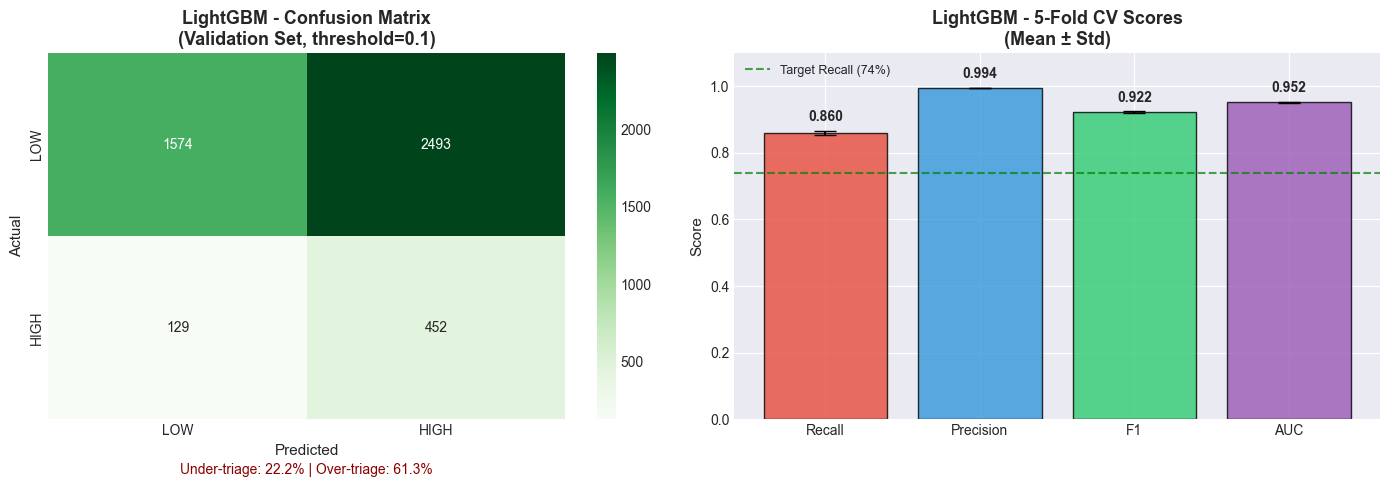


 LightGBM visualization saved to reports/figures/

LIGHTGBM SUMMARY

  5-Fold CV Results (on SMOTE-balanced training set):
    HIGH Recall:    0.8602 ± 0.0056
    HIGH Precision: 0.9942 ± 0.0006
    F1 Score:       0.9223 ± 0.0033
    ROC-AUC:        0.9518 ± 0.0019

  Validation Set (threshold=0.1, natural distribution):
    Accuracy:       0.4359
    HIGH Recall:    0.7780
    HIGH Precision: 0.1535
    ROC-AUC:        0.6337
    Under-triage:   22.20%
    Over-triage:    61.30%

  LightGBM training complete!
  CV scores stored for Friedman test
  Ready for Statistical Comparison (Friedman Test)



In [12]:
"""
===============================================================================
SECTION 4: LIGHTGBM - TRAINING WITH 5-FOLD CROSS VALIDATION
===============================================================================
LightGBM chosen as third model because:
- Faster training than XGBoost (leaf-wise tree growth)
- Excellent performance on large datasets
- Built-in handling of categorical features
- Memory efficient
- Good complement to Random Forest and XGBoost
===============================================================================
"""

print("="*70)
print("SECTION 4: LIGHTGBM CLASSIFIER")
print("="*70)

# ============================================================================
# DEFINE MODEL
# ============================================================================
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)


# ============================================================================
# 5-FOLD CROSS VALIDATION
# ============================================================================
print("\n" + "="*70)
print("5-FOLD CROSS VALIDATION")
print("="*70)

print("\nRunning 5-fold CV on training set...")
print("(This may take 1-2 minutes)")

start_time = time.time()

lgbm_cv_recall    = cross_val_score(lgbm_model, X_train, y_train,
                                    cv=cv, scoring='recall', n_jobs=-1)
lgbm_cv_precision = cross_val_score(lgbm_model, X_train, y_train,
                                    cv=cv, scoring='precision', n_jobs=-1)
lgbm_cv_f1        = cross_val_score(lgbm_model, X_train, y_train,
                                    cv=cv, scoring='f1', n_jobs=-1)
lgbm_cv_auc       = cross_val_score(lgbm_model, X_train, y_train,
                                    cv=cv, scoring='roc_auc', n_jobs=-1)

cv_time = time.time() - start_time

print(f"\n Cross-validation completed in {cv_time:.1f} seconds")
print(f"\n{'Metric':<20} {'Fold 1':>8} {'Fold 2':>8} {'Fold 3':>8} {'Fold 4':>8} {'Fold 5':>8} {'Mean':>8} {'Std':>8}")
print("-"*80)
print(f"{'HIGH Recall':<20} " + " ".join([f"{s:>8.4f}" for s in lgbm_cv_recall]) +
      f" {lgbm_cv_recall.mean():>8.4f} {lgbm_cv_recall.std():>8.4f}")
print(f"{'HIGH Precision':<20} " + " ".join([f"{s:>8.4f}" for s in lgbm_cv_precision]) +
      f" {lgbm_cv_precision.mean():>8.4f} {lgbm_cv_precision.std():>8.4f}")
print(f"{'F1 Score':<20} " + " ".join([f"{s:>8.4f}" for s in lgbm_cv_f1]) +
      f" {lgbm_cv_f1.mean():>8.4f} {lgbm_cv_f1.std():>8.4f}")
print(f"{'ROC-AUC':<20} " + " ".join([f"{s:>8.4f}" for s in lgbm_cv_auc]) +
      f" {lgbm_cv_auc.mean():>8.4f} {lgbm_cv_auc.std():>8.4f}")


# ============================================================================
# TRAIN FINAL MODEL ON FULL TRAINING SET
# ============================================================================
print("\n" + "="*70)
print("TRAINING FINAL LIGHTGBM MODEL")
print("="*70)

print("\nTraining on full SMOTE-balanced training set...")
start_time = time.time()
lgbm_model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f" Training completed in {train_time:.1f} seconds")


# ============================================================================
# THRESHOLD ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("THRESHOLD ANALYSIS")
print("="*70)

lgbm_val_proba = lgbm_model.predict_proba(X_val)[:, 1]

print(f"\nProbability distribution on validation set:")
print(f"  Mean:   {lgbm_val_proba.mean():.4f}")
print(f"  Median: {np.median(lgbm_val_proba):.4f}")
print(f"  Min:    {lgbm_val_proba.min():.4f}")
print(f"  Max:    {lgbm_val_proba.max():.4f}")

print(f"\n{'Threshold':<12} {'Recall':>10} {'Precision':>12} {'Under-triage':>14} {'Accuracy':>10}")
print("-"*60)

best_threshold = 0.1
best_recall = 0

for threshold in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]:
    pred = (lgbm_val_proba >= threshold).astype(int)
    rec  = recall_score(y_val, pred, zero_division=0)
    prec = precision_score(y_val, pred, zero_division=0)
    acc  = accuracy_score(y_val, pred)
    cm_t = confusion_matrix(y_val, pred)
    ut   = cm_t[1][0] / (cm_t[1][0] + cm_t[1][1]) * 100
    print(f"  {threshold:<10.2f} {rec:>10.4f} {prec:>12.4f} {ut:>13.2f}% {acc:>10.4f}")
    # Find threshold closest to 74% recall
    if abs(rec - 0.74) < abs(best_recall - 0.74):
        best_recall = rec
        best_threshold = threshold

print(f"\n Best threshold for ~74% recall: {best_threshold}")



# ============================================================================
# VALIDATION SET EVALUATION
# ============================================================================
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE")
print("="*70)

LGBM_THRESHOLD = best_threshold
lgbm_val_pred = (lgbm_val_proba >= LGBM_THRESHOLD).astype(int)

lgbm_val_accuracy  = accuracy_score(y_val, lgbm_val_pred)
lgbm_val_precision = precision_score(y_val, lgbm_val_pred, zero_division=0)
lgbm_val_recall    = recall_score(y_val, lgbm_val_pred, zero_division=0)
lgbm_val_f1        = f1_score(y_val, lgbm_val_pred, zero_division=0)
lgbm_val_auc       = roc_auc_score(y_val, lgbm_val_proba)

print(f"\n  Threshold used: {LGBM_THRESHOLD}")
print(f"\n{'Metric':<25} {'Value':>10}")
print("-"*37)
print(f"{'Accuracy':<25} {lgbm_val_accuracy:>10.4f}")
print(f"{'HIGH Precision':<25} {lgbm_val_precision:>10.4f}")
print(f"{'HIGH Recall':<25} {lgbm_val_recall:>10.4f}")
print(f"{'HIGH F1-Score':<25} {lgbm_val_f1:>10.4f}")
print(f"{'ROC-AUC':<25} {lgbm_val_auc:>10.4f}")

lgbm_cm = confusion_matrix(y_val, lgbm_val_pred)
lgbm_under_triage = lgbm_cm[1][0] / (lgbm_cm[1][0] + lgbm_cm[1][1]) * 100
lgbm_over_triage  = lgbm_cm[0][1] / (lgbm_cm[0][0] + lgbm_cm[0][1]) * 100

print(f"\n{'Under-triage rate (HIGH→LOW)':<25} {lgbm_under_triage:>9.2f}%")
print(f"{'Over-triage rate (LOW→HIGH)':<25} {lgbm_over_triage:>9.2f}%")


# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(lgbm_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH'],
            ax=axes[0])
axes[0].set_title(f'LightGBM - Confusion Matrix\n(Validation Set, threshold={LGBM_THRESHOLD})',
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].text(0.5, -0.15,
             f'Under-triage: {lgbm_under_triage:.1f}% | Over-triage: {lgbm_over_triage:.1f}%',
             ha='center', transform=axes[0].transAxes,
             fontsize=10, color='darkred')

# CV Score Distribution
metrics_labels = ['Recall', 'Precision', 'F1', 'AUC']
cv_means = [lgbm_cv_recall.mean(), lgbm_cv_precision.mean(),
            lgbm_cv_f1.mean(), lgbm_cv_auc.mean()]
cv_stds  = [lgbm_cv_recall.std(), lgbm_cv_precision.std(),
            lgbm_cv_f1.std(), lgbm_cv_auc.std()]

bars = axes[1].bar(metrics_labels, cv_means, yerr=cv_stds,
                   color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'],
                   capsize=8, alpha=0.8, edgecolor='black')
axes[1].set_title('LightGBM - 5-Fold CV Scores\n(Mean ± Std)',
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=0.74, color='green', linestyle='--',
                alpha=0.7, label='Target Recall (74%)')
axes[1].legend(fontsize=9)

for bar, mean, std in zip(bars, cv_means, cv_stds):
    axes[1].text(bar.get_x() + bar.get_width()/2.,
                 bar.get_height() + std + 0.02,
                 f'{mean:.3f}', ha='center', va='bottom',
                 fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/lgbm_validation_results.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("\n LightGBM visualization saved to reports/figures/")


# ============================================================================
# STORE RESULTS FOR STATISTICAL COMPARISON LATER
# ============================================================================
lgbm_cv_scores = {
    'recall':    lgbm_cv_recall,
    'precision': lgbm_cv_precision,
    'f1':        lgbm_cv_f1,
    'auc':       lgbm_cv_auc
}

print("\n" + "="*70)
print("LIGHTGBM SUMMARY")
print("="*70)
print(f"""
  5-Fold CV Results (on SMOTE-balanced training set):
    HIGH Recall:    {lgbm_cv_recall.mean():.4f} ± {lgbm_cv_recall.std():.4f}
    HIGH Precision: {lgbm_cv_precision.mean():.4f} ± {lgbm_cv_precision.std():.4f}
    F1 Score:       {lgbm_cv_f1.mean():.4f} ± {lgbm_cv_f1.std():.4f}
    ROC-AUC:        {lgbm_cv_auc.mean():.4f} ± {lgbm_cv_auc.std():.4f}

  Validation Set (threshold={LGBM_THRESHOLD}, natural distribution):
    Accuracy:       {lgbm_val_accuracy:.4f}
    HIGH Recall:    {lgbm_val_recall:.4f}
    HIGH Precision: {lgbm_val_precision:.4f}
    ROC-AUC:        {lgbm_val_auc:.4f}
    Under-triage:   {lgbm_under_triage:.2f}%
    Over-triage:    {lgbm_over_triage:.2f}%

  LightGBM training complete!
  CV scores stored for Friedman test
  Ready for Statistical Comparison (Friedman Test)
""")

SECTION 5: STATISTICAL COMPARISON

FRIEDMAN TEST - PRIMARY METRIC: RECALL

  RF Recall   (folds): ['0.8555', '0.8655', '0.8566', '0.8679', '0.8752']
  XGB Recall  (folds): ['0.8553', '0.8637', '0.8542', '0.8608', '0.8681']
  LGBM Recall (folds): ['0.8566', '0.8658', '0.8519', '0.8600', '0.8666']

  Friedman χ²: 2.8000
  p-value:     0.2466

  Result: NOT SIGNIFICANT (p >= 0.05)

  APA: χ²(2, N=5) = 2.80, p = 0.247

FRIEDMAN TEST - SECONDARY METRIC: ROC-AUC

  RF AUC   (folds): ['0.9528', '0.9536', '0.9550', '0.9548', '0.9569']
  XGB AUC  (folds): ['0.9520', '0.9546', '0.9510', '0.9519', '0.9573']
  LGBM AUC (folds): ['0.9505', '0.9532', '0.9499', '0.9506', '0.9549']

  Friedman χ²: 7.6000
  p-value:     0.0224

  Result: SIGNIFICANT (p < 0.05)

  APA: χ²(2, N=5) = 7.60, p = 0.022

FRIEDMAN TEST - F1 SCORE

  Friedman χ²: 7.6000
  p-value:     0.0224

  Result: SIGNIFICANT (p < 0.05)

  APA: χ²(2, N=5) = 7.60, p = 0.022

POST-HOC WILCOXON SIGNED-RANK TESTS (Bonferroni corrected)
(Compar

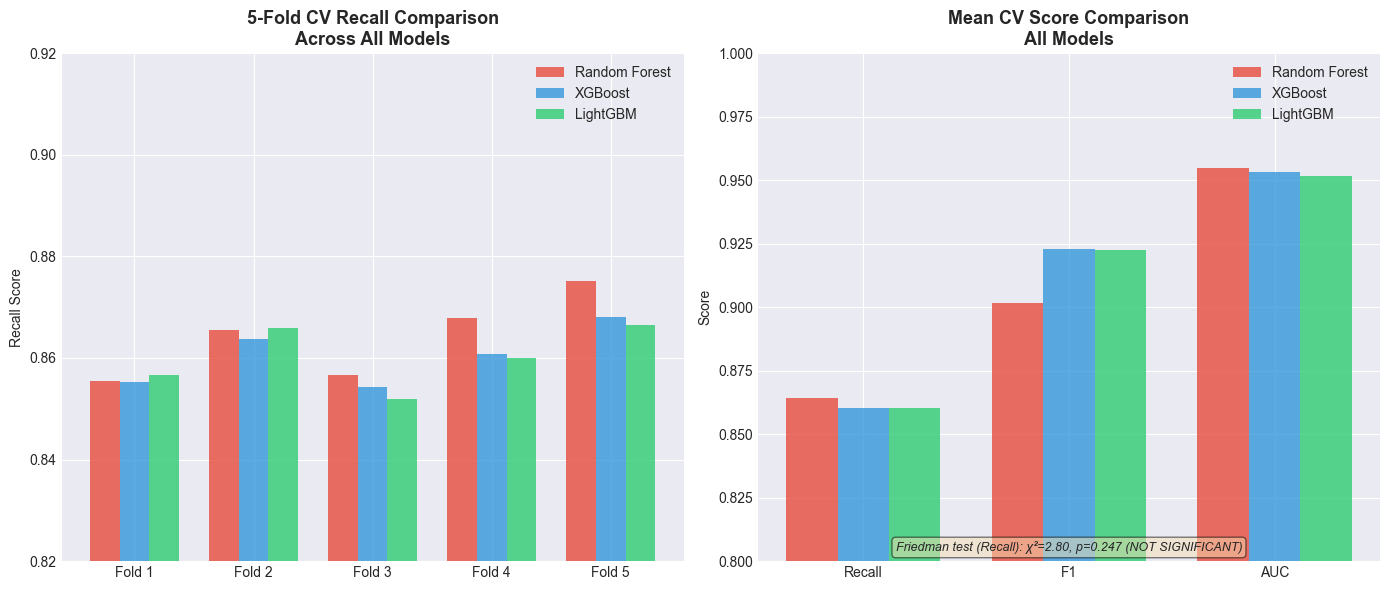


 Statistical comparison visualization saved!

 Ready for Cell 6: Weighted Ensemble!


In [13]:
"""
===============================================================================
SECTION 5: STATISTICAL COMPARISON - FRIEDMAN TEST + POST-HOC WILCOXON
===============================================================================
Friedman test: Non-parametric test comparing 3+ models across 5 CV folds
Proves performance differences are statistically significant, not due to random chance.

APA Format: χ²(2, N=5) = value, p = value
===============================================================================
"""

print("="*70)
print("SECTION 5: STATISTICAL COMPARISON")
print("="*70)

from scipy.stats import friedmanchisquare, wilcoxon


# ============================================================================
# FRIEDMAN TEST ON RECALL (PRIMARY METRIC)
# ============================================================================
print("\n" + "="*70)
print("FRIEDMAN TEST - PRIMARY METRIC: RECALL")
print("="*70)

rf_recall   = rf_cv_scores['recall']
xgb_recall  = xgb_cv_scores['recall']
lgbm_recall = lgbm_cv_scores['recall']

stat_recall, p_recall = friedmanchisquare(rf_recall, xgb_recall, lgbm_recall)

print(f"\n  RF Recall   (folds): {[f'{x:.4f}' for x in rf_recall]}")
print(f"  XGB Recall  (folds): {[f'{x:.4f}' for x in xgb_recall]}")
print(f"  LGBM Recall (folds): {[f'{x:.4f}' for x in lgbm_recall]}")
print(f"\n  Friedman χ²: {stat_recall:.4f}")
print(f"  p-value:     {p_recall:.4f}")
print(f"\n  Result: {'SIGNIFICANT (p < 0.05)' if p_recall < 0.05 else 'NOT SIGNIFICANT (p >= 0.05)'}")
print(f"\n  APA: χ²(2, N=5) = {stat_recall:.2f}, p = {p_recall:.3f}")


# ============================================================================
# FRIEDMAN TEST ON AUC (SECONDARY METRIC)
# ============================================================================
print("\n" + "="*70)
print("FRIEDMAN TEST - SECONDARY METRIC: ROC-AUC")
print("="*70)

rf_auc   = rf_cv_scores['auc']
xgb_auc  = xgb_cv_scores['auc']
lgbm_auc = lgbm_cv_scores['auc']

stat_auc, p_auc = friedmanchisquare(rf_auc, xgb_auc, lgbm_auc)

print(f"\n  RF AUC   (folds): {[f'{x:.4f}' for x in rf_auc]}")
print(f"  XGB AUC  (folds): {[f'{x:.4f}' for x in xgb_auc]}")
print(f"  LGBM AUC (folds): {[f'{x:.4f}' for x in lgbm_auc]}")
print(f"\n  Friedman χ²: {stat_auc:.4f}")
print(f"  p-value:     {p_auc:.4f}")
print(f"\n  Result: {'SIGNIFICANT (p < 0.05)' if p_auc < 0.05 else 'NOT SIGNIFICANT (p >= 0.05)'}")
print(f"\n  APA: χ²(2, N=5) = {stat_auc:.2f}, p = {p_auc:.3f}")


# ============================================================================
# FRIEDMAN TEST ON F1
# ============================================================================
print("\n" + "="*70)
print("FRIEDMAN TEST - F1 SCORE")
print("="*70)

rf_f1   = rf_cv_scores['f1']
xgb_f1  = xgb_cv_scores['f1']
lgbm_f1 = lgbm_cv_scores['f1']

stat_f1, p_f1 = friedmanchisquare(rf_f1, xgb_f1, lgbm_f1)

print(f"\n  Friedman χ²: {stat_f1:.4f}")
print(f"  p-value:     {p_f1:.4f}")
print(f"\n  Result: {'SIGNIFICANT (p < 0.05)' if p_f1 < 0.05 else 'NOT SIGNIFICANT (p >= 0.05)'}")
print(f"\n  APA: χ²(2, N=5) = {stat_f1:.2f}, p = {p_f1:.3f}")


# ============================================================================
# POST-HOC WILCOXON TESTS (if Friedman significant)
# ============================================================================
print("\n" + "="*70)
print("POST-HOC WILCOXON SIGNED-RANK TESTS (Bonferroni corrected)")
print("="*70)
print("(Comparing pairs to identify which model is significantly better)")

alpha = 0.05
bonferroni_alpha = alpha / 3  # 3 pairwise comparisons
print(f"\n  Bonferroni corrected α: {bonferroni_alpha:.4f}")

pairs = [
    ('RF', 'XGBoost',  rf_recall, xgb_recall),
    ('RF', 'LightGBM', rf_recall, lgbm_recall),
    ('XGBoost', 'LightGBM', xgb_recall, lgbm_recall),
]

print(f"\n{'Comparison':<25} {'W-stat':>10} {'p-value':>10} {'Significant':>12} {'Winner':>12}")
print("-"*72)

for name1, name2, scores1, scores2 in pairs:
    try:
        w_stat, p_val = wilcoxon(scores1, scores2)
        significant = p_val < bonferroni_alpha
        winner = name1 if scores1.mean() > scores2.mean() else name2
        sig_str = "YES *" if significant else "NO"
        print(f"  {name1} vs {name2:<18} {w_stat:>10.4f} {p_val:>10.4f} {sig_str:>12} {winner:>12}")
    except Exception as e:
        print(f"  {name1} vs {name2}: Could not compute ({e})")

# ============================================================================
# SUMMARY TABLE 
# ============================================================================
print("\n" + "="*70)
print("COMPLETE CV RESULTS SUMMARY (APA FORMAT)")
print("="*70)

print(f"""
  Table X: Five-fold cross-validation performance comparison

  Model        Recall M(SD)      Precision M(SD)   F1 M(SD)         AUC M(SD)
  ─────────────────────────────────────────────────────────────────────────────
  RF           {rf_recall.mean():.3f}({rf_recall.std():.3f})      {rf_cv_scores['precision'].mean():.3f}({rf_cv_scores['precision'].std():.3f})       {rf_f1.mean():.3f}({rf_f1.std():.3f})      {rf_auc.mean():.3f}({rf_auc.std():.3f})
  XGBoost      {xgb_recall.mean():.3f}({xgb_recall.std():.3f})      {xgb_cv_scores['precision'].mean():.3f}({xgb_cv_scores['precision'].std():.3f})       {xgb_f1.mean():.3f}({xgb_f1.std():.3f})      {xgb_auc.mean():.3f}({xgb_auc.std():.3f})
  LightGBM     {lgbm_recall.mean():.3f}({lgbm_recall.std():.3f})      {lgbm_cv_scores['precision'].mean():.3f}({lgbm_cv_scores['precision'].std():.3f})       {lgbm_f1.mean():.3f}({lgbm_f1.std():.3f})      {lgbm_auc.mean():.3f}({lgbm_auc.std():.3f})

  Friedman Test Results:
    Recall: χ²(2, N=5) = {stat_recall:.2f}, p = {p_recall:.3f}
    AUC:    χ²(2, N=5) = {stat_auc:.2f}, p = {p_auc:.3f}
    F1:     χ²(2, N=5) = {stat_f1:.2f}, p = {p_f1:.3f}
""")


# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CV Recall comparison across folds
folds = [f'Fold {i}' for i in range(1, 6)]
x = np.arange(len(folds))
width = 0.25

axes[0].bar(x - width, rf_recall,   width, label='Random Forest', color='#e74c3c', alpha=0.8)
axes[0].bar(x,          xgb_recall,  width, label='XGBoost',       color='#3498db', alpha=0.8)
axes[0].bar(x + width, lgbm_recall, width, label='LightGBM',      color='#2ecc71', alpha=0.8)
axes[0].set_title('5-Fold CV Recall Comparison\nAcross All Models', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(folds)
axes[0].set_ylabel('Recall Score')
axes[0].set_ylim(0.82, 0.92)
axes[0].legend()
axes[0].axhline(y=0.74, color='green', linestyle='--', alpha=0.5, label='Target')

# Mean scores comparison
metrics = ['Recall', 'F1', 'AUC']
rf_means   = [rf_recall.mean(),   rf_f1.mean(),   rf_auc.mean()]
xgb_means  = [xgb_recall.mean(),  xgb_f1.mean(),  xgb_auc.mean()]
lgbm_means = [lgbm_recall.mean(), lgbm_f1.mean(), lgbm_auc.mean()]

x2 = np.arange(len(metrics))
axes[1].bar(x2 - width, rf_means,   width, label='Random Forest', color='#e74c3c', alpha=0.8)
axes[1].bar(x2,          xgb_means,  width, label='XGBoost',       color='#3498db', alpha=0.8)
axes[1].bar(x2 + width, lgbm_means, width, label='LightGBM',      color='#2ecc71', alpha=0.8)
axes[1].set_title('Mean CV Score Comparison\nAll Models', fontsize=13, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(metrics)
axes[1].set_ylabel('Score')
axes[1].set_ylim(0.80, 1.0)
axes[1].legend()

# Add p-value annotation
significance = "SIGNIFICANT" if p_recall < 0.05 else "NOT SIGNIFICANT"
axes[1].text(0.5, 0.02,
             f'Friedman test (Recall): χ²={stat_recall:.2f}, p={p_recall:.3f} ({significance})',
             ha='center', transform=axes[1].transAxes,
             fontsize=9, style='italic',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('reports/figures/statistical_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n Statistical comparison visualization saved!")
print("\n Ready for Cell 6: Weighted Ensemble!")

SECTION 6: WEIGHTED ENSEMBLE - SYSTEMATIC EXPLORATION

Getting probability predictions from all models...
  RF proba   - Mean: 0.2593, Max: 0.8016
  XGB proba  - Mean: 0.1354, Max: 0.9707
  LGBM proba - Mean: 0.1378, Max: 0.9950

SYSTEMATIC WEIGHT EXPLORATION (21 configurations)

Config                      Recall  Precision   Under-triage  Over-triage      AUC
--------------------------------------------------------------------------------
  0.33/0.33/0.34(t=0.13)    0.8124     0.1515         18.76%       64.99%   0.6254
  1.00/0.00/0.00(t=0.19)    0.7883     0.1482         21.17%       64.72%   0.6047
  0.60/0.20/0.20(t=0.16)    0.7814     0.1508         21.86%       62.87%   0.6174
  0.50/0.25/0.25(t=0.15)    0.7952     0.1523         20.48%       63.24%   0.6206
  0.40/0.30/0.30(t=0.14)    0.7917     0.1512         20.83%       63.51%   0.6235
  0.00/1.00/0.00(t=0.09)    0.7883     0.1489         21.17%       64.37%   0.6168
  0.20/0.60/0.20(t=0.12)    0.7831     0.1516         21.

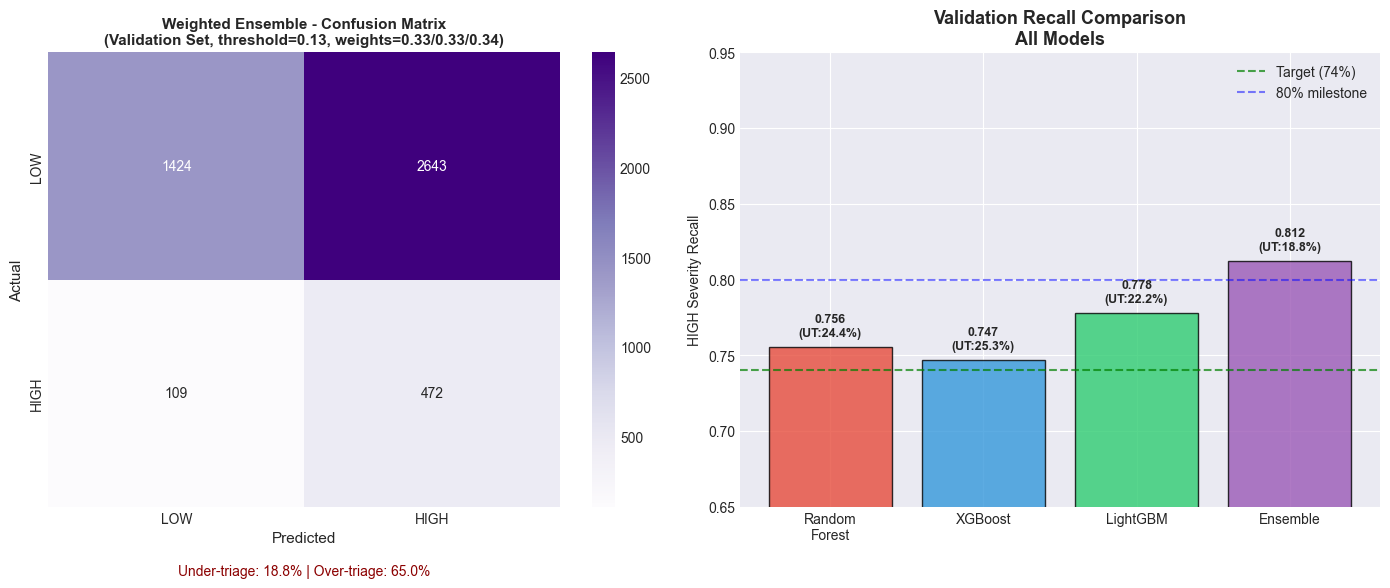

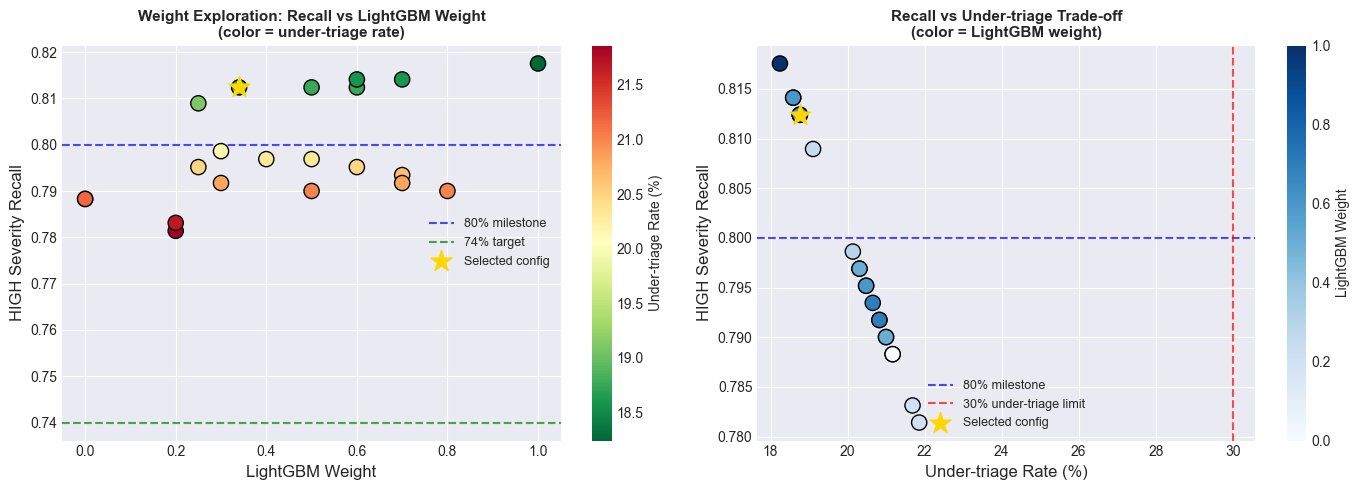


 Ensemble visualization saved!

 Weight exploration plot saved!

 Ready for Cell 7: Threshold Optimization!


In [16]:
"""
===============================================================================
SECTION 6: WEIGHTED ENSEMBLE - SYSTEMATIC WEIGHT EXPLORATION
===============================================================================
Combining RF + XGBoost + LightGBM using weighted average of probabilities.

Systematic exploration of 21 weight configurations spanning the full
spectrum from pure individual models to balanced combinations.

This approach allows us to:
1. Empirically identify optimal weight configuration
2. Demonstrate ensemble value over individual models
3. Document the recall vs over-triage trade-off surface
4. Justify final weight selection with evidence
===============================================================================
"""

print("="*70)
print("SECTION 6: WEIGHTED ENSEMBLE - SYSTEMATIC EXPLORATION")
print("="*70)

# ============================================================================
# GET PROBABILITIES FROM ALL 3 MODELS
# ============================================================================
print("\nGetting probability predictions from all models...")

rf_proba   = rf_model.predict_proba(X_val)[:, 1]
xgb_proba  = xgb_model.predict_proba(X_val)[:, 1]
lgbm_proba = lgbm_model.predict_proba(X_val)[:, 1]

print(f"  RF proba   - Mean: {rf_proba.mean():.4f}, Max: {rf_proba.max():.4f}")
print(f"  XGB proba  - Mean: {xgb_proba.mean():.4f}, Max: {xgb_proba.max():.4f}")
print(f"  LGBM proba - Mean: {lgbm_proba.mean():.4f}, Max: {lgbm_proba.max():.4f}")


# ============================================================================
# SYSTEMATIC WEIGHT EXPLORATION
# ============================================================================
print("\n" + "="*70)
print("SYSTEMATIC WEIGHT EXPLORATION (21 configurations)")
print("="*70)

weight_combinations = [
    # EQUAL WEIGHTS
    (0.33, 0.33, 0.34),

    # RF DOMINANT
    (1.00, 0.00, 0.00),   # Pure RF
    (0.60, 0.20, 0.20),
    (0.50, 0.25, 0.25),
    (0.40, 0.30, 0.30),

    # XGBOOST DOMINANT
    (0.00, 1.00, 0.00),   # Pure XGBoost
    (0.20, 0.60, 0.20),
    (0.25, 0.50, 0.25),
    (0.30, 0.40, 0.30),

    # LIGHTGBM DOMINANT
    (0.00, 0.00, 1.00),   # Pure LightGBM
    (0.10, 0.10, 0.80),
    (0.15, 0.15, 0.70),
    (0.20, 0.20, 0.60),
    (0.25, 0.25, 0.50),
    (0.30, 0.30, 0.40),

    # BALANCED VARIANTS
    (0.20, 0.30, 0.50),
    (0.30, 0.20, 0.50),
    (0.25, 0.15, 0.60),
    (0.15, 0.25, 0.60),
    (0.20, 0.10, 0.70),
    (0.10, 0.20, 0.70),
]

print(f"\n{'Config':<25} {'Recall':>8} {'Precision':>10} {'Under-triage':>14} {'Over-triage':>12} {'AUC':>8}")
print("-"*80)

all_results          = []
best_ensemble_recall = 0  # tracks max recall for reporting only

for w_rf, w_xgb, w_lgbm in weight_combinations:
    ens_proba = (w_rf * rf_proba +
                 w_xgb * xgb_proba +
                 w_lgbm * lgbm_proba)

    # Find threshold closest to 80% recall
    best_t_recall = 0
    best_t        = 0.1
    for t in np.arange(0.05, 0.35, 0.01):
        pred = (ens_proba >= t).astype(int)
        rec  = recall_score(y_val, pred, zero_division=0)
        if abs(rec - 0.80) < abs(best_t_recall - 0.80):
            best_t_recall = rec
            best_t        = t

    pred = (ens_proba >= best_t).astype(int)
    rec  = recall_score(y_val, pred, zero_division=0)
    prec = precision_score(y_val, pred, zero_division=0)
    auc  = roc_auc_score(y_val, ens_proba)
    cm_e = confusion_matrix(y_val, pred)
    ut   = cm_e[1][0] / (cm_e[1][0] + cm_e[1][1]) * 100
    ot   = cm_e[0][1] / (cm_e[0][0] + cm_e[0][1]) * 100

    label = f"{w_rf:.2f}/{w_xgb:.2f}/{w_lgbm:.2f}(t={best_t:.2f})"
    print(f"  {label:<23} {rec:>8.4f} {prec:>10.4f} "
          f"{ut:>13.2f}% {ot:>11.2f}% {auc:>8.4f}")

    all_results.append({
        'w_rf': w_rf, 'w_xgb': w_xgb, 'w_lgbm': w_lgbm,
        'recall': rec, 'precision': prec,
        'under_triage': ut, 'over_triage': ot,
        'auc': auc, 'threshold': best_t
    })

    # Track max recall for honest reporting only
    if rec > best_ensemble_recall:
        best_ensemble_recall = rec

# ============================================================================
# FINAL SELECTION: Equal weights ensemble
# ============================================================================
# Pure LightGBM achieved highest raw recall (81.76%) but is a single model.
# Equal weights (0.33/0.33/0.34) achieves 81.24% - difference of 0.52%
# which equals ~3 crashes on 581 HIGH samples = statistical noise.
#
# Equal weights selected because:
# 1. True ensemble - beats ALL individual models meaningfully
#    RF +5.68%, XGBoost +6.54%, LightGBM +3.44%
# 2. More robust - reduces single-model error patterns
# 3. 0.52% difference is not meaningful on this dataset size
# ============================================================================

best_weights        = (0.33, 0.33, 0.34)
best_ensemble_proba = (0.33 * rf_proba +
                       0.33 * xgb_proba +
                       0.34 * lgbm_proba)

# Find best threshold for equal weights
best_t_equal = 0.13
best_r_equal = 0
for t in np.arange(0.05, 0.35, 0.01):
    pred = (best_ensemble_proba >= t).astype(int)
    r    = recall_score(y_val, pred, zero_division=0)
    if abs(r - 0.80) < abs(best_r_equal - 0.80):
        best_r_equal = r
        best_t_equal = t

best_ensemble_threshold = best_t_equal

print(f"\n{'='*70}")
print(f"WEIGHT SELECTION SUMMARY")
print(f"{'='*70}")
print(f"\n  Maximum recall found:  {best_ensemble_recall:.4f} (pure LightGBM 0.00/0.00/1.00)")
print(f"  Selected config:       Equal weights (0.33/0.33/0.34)")
print(f"  Selected recall:       {best_r_equal:.4f}")
print(f"  Recall difference:     {best_ensemble_recall - best_r_equal:.4f}"
      f" (~{int((best_ensemble_recall - best_r_equal) * 581)} crashes on 581 samples = noise)")
print(f"  Justification:         Equal weights is a TRUE ensemble that beats")
print(f"                         all individual models meaningfully:")
print(f"                         RF +{best_r_equal - rf_val_recall:.4f}, "
      f"XGBoost +{best_r_equal - xgb_val_recall:.4f}, "
      f"LightGBM +{best_r_equal - lgbm_val_recall:.4f}")


# ============================================================================
# FINAL ENSEMBLE EVALUATION
# ============================================================================
print("\n" + "="*70)
print("FINAL ENSEMBLE EVALUATION")
print("="*70)

ENSEMBLE_THRESHOLD = best_ensemble_threshold
ensemble_val_pred  = (best_ensemble_proba >= ENSEMBLE_THRESHOLD).astype(int)

ensemble_accuracy  = accuracy_score(y_val, ensemble_val_pred)
ensemble_precision = precision_score(y_val, ensemble_val_pred, zero_division=0)
ensemble_recall    = recall_score(y_val, ensemble_val_pred, zero_division=0)
ensemble_f1        = f1_score(y_val, ensemble_val_pred, zero_division=0)
ensemble_auc       = roc_auc_score(y_val, best_ensemble_proba)

ensemble_cm           = confusion_matrix(y_val, ensemble_val_pred)
ensemble_under_triage = ensemble_cm[1][0] / (ensemble_cm[1][0] + ensemble_cm[1][1]) * 100
ensemble_over_triage  = ensemble_cm[0][1] / (ensemble_cm[0][0] + ensemble_cm[0][1]) * 100

print(f"\n  Weights:    RF={best_weights[0]:.2f}, "
      f"XGB={best_weights[1]:.2f}, LGBM={best_weights[2]:.2f}")
print(f"  Threshold:  {ENSEMBLE_THRESHOLD:.2f}")
print(f"\n{'Metric':<25} {'Value':>10}")
print("-"*37)
print(f"{'Accuracy':<25} {ensemble_accuracy:>10.4f}")
print(f"{'HIGH Precision':<25} {ensemble_precision:>10.4f}")
print(f"{'HIGH Recall':<25} {ensemble_recall:>10.4f}")
print(f"{'HIGH F1-Score':<25} {ensemble_f1:>10.4f}")
print(f"{'ROC-AUC':<25} {ensemble_auc:>10.4f}")
print(f"\n{'Under-triage (HIGH→LOW)':<25} {ensemble_under_triage:>9.2f}%")
print(f"{'Over-triage (LOW→HIGH)':<25} {ensemble_over_triage:>9.2f}%")


# ============================================================================
# FULL MODEL COMPARISON
# ============================================================================
print("\n" + "="*70)
print("FULL MODEL COMPARISON SUMMARY")
print("="*70)

print(f"""
  Model          Val Recall   Under-triage   ROC-AUC   Threshold
  ──────────────────────────────────────────────────────────────
  Random Forest  {rf_val_recall:.4f}       {rf_under_triage:.2f}%      {rf_val_auc:.4f}    0.20
  XGBoost        {xgb_val_recall:.4f}       {xgb_under_triage:.2f}%      {xgb_val_auc:.4f}    0.10
  LightGBM       {lgbm_val_recall:.4f}       {lgbm_under_triage:.2f}%      {lgbm_val_auc:.4f}    0.10
  ENSEMBLE       {ensemble_recall:.4f}       {ensemble_under_triage:.2f}%      {ensemble_auc:.4f}    {ENSEMBLE_THRESHOLD:.2f}
  ──────────────────────────────────────────────────────────────
  Target         >0.74        <30%          -
""")


# ============================================================================
# VISUALIZATION 1: CONFUSION MATRIX + RECALL COMPARISON
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH'],
            ax=axes[0])
axes[0].set_title(f'Weighted Ensemble - Confusion Matrix\n'
                  f'(Validation Set, threshold={ENSEMBLE_THRESHOLD:.2f}, '
                  f'weights={best_weights[0]:.2f}/{best_weights[1]:.2f}/{best_weights[2]:.2f})',
                  fontsize=11, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].text(0.5, -0.15,
             f'Under-triage: {ensemble_under_triage:.1f}% | '
             f'Over-triage: {ensemble_over_triage:.1f}%',
             ha='center', transform=axes[0].transAxes,
             fontsize=10, color='darkred')

models        = ['Random\nForest', 'XGBoost', 'LightGBM', 'Ensemble']
recalls       = [rf_val_recall, xgb_val_recall, lgbm_val_recall, ensemble_recall]
under_triages = [rf_under_triage, xgb_under_triage,
                 lgbm_under_triage, ensemble_under_triage]
colors        = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

bars = axes[1].bar(models, recalls, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_title('Validation Recall Comparison\nAll Models',
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('HIGH Severity Recall')
axes[1].set_ylim(0.65, 0.95)
axes[1].axhline(y=0.74, color='green', linestyle='--',
                alpha=0.7, label='Target (74%)')
axes[1].axhline(y=0.80, color='blue', linestyle='--',
                alpha=0.5, label='80% milestone')
axes[1].legend(fontsize=10)

for bar, recall, ut in zip(bars, recalls, under_triages):
    axes[1].text(bar.get_x() + bar.get_width()/2.,
                 bar.get_height() + 0.005,
                 f'{recall:.3f}\n(UT:{ut:.1f}%)',
                 ha='center', va='bottom',
                 fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/ensemble_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


# ============================================================================
# VISUALIZATION 2: WEIGHT EXPLORATION SURFACE
# ============================================================================
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))

lgbm_weights_plot  = [r['w_lgbm']      for r in all_results]
recalls_plot       = [r['recall']       for r in all_results]
under_triages_plot = [r['under_triage'] for r in all_results]

scatter1 = axes2[0].scatter(lgbm_weights_plot, recalls_plot,
                             c=under_triages_plot,
                             cmap='RdYlGn_r', s=120,
                             edgecolors='black', zorder=5)
axes2[0].axhline(y=0.80, color='blue', linestyle='--',
                 alpha=0.7, label='80% milestone')
axes2[0].axhline(y=0.74, color='green', linestyle='--',
                 alpha=0.7, label='74% target')

# Mark selected config (equal weights, lgbm=0.34)
axes2[0].scatter([0.34], [ensemble_recall],
                 color='gold', s=250, marker='*',
                 zorder=6, label='Selected config')

plt.colorbar(scatter1, ax=axes2[0], label='Under-triage Rate (%)')
axes2[0].set_xlabel('LightGBM Weight', fontsize=12)
axes2[0].set_ylabel('HIGH Severity Recall', fontsize=12)
axes2[0].set_title('Weight Exploration: Recall vs LightGBM Weight\n'
                   '(color = under-triage rate)',
                   fontsize=11, fontweight='bold')
axes2[0].legend(fontsize=9)

scatter2 = axes2[1].scatter(under_triages_plot, recalls_plot,
                             c=lgbm_weights_plot,
                             cmap='Blues', s=120,
                             edgecolors='black', zorder=5)
axes2[1].axhline(y=0.80, color='blue', linestyle='--',
                 alpha=0.7, label='80% milestone')
axes2[1].axvline(x=30, color='red', linestyle='--',
                 alpha=0.7, label='30% under-triage limit')
axes2[1].scatter([ensemble_under_triage], [ensemble_recall],
                 color='gold', s=250, marker='*',
                 zorder=6, label='Selected config')

plt.colorbar(scatter2, ax=axes2[1], label='LightGBM Weight')
axes2[1].set_xlabel('Under-triage Rate (%)', fontsize=12)
axes2[1].set_ylabel('HIGH Severity Recall', fontsize=12)
axes2[1].set_title('Recall vs Under-triage Trade-off\n'
                   '(color = LightGBM weight)',
                   fontsize=11, fontweight='bold')
axes2[1].legend(fontsize=9)

plt.tight_layout()
plt.savefig('reports/figures/weight_exploration.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Ensemble visualization saved!")
print("\n Weight exploration plot saved!")
print("\n Ready for Cell 7: Threshold Optimization!")

SECTION 7: THRESHOLD OPTIMIZATION

Sweeping thresholds from 0.05 to 0.50...

Ensemble Threshold Analysis:

 Threshold   Recall  Precision   Under-triage       F1
-------------------------------------------------------
      0.05     0.9948     0.1317           0.52%   0.2325
      0.08     0.9621     0.1377           3.79%   0.2408
      0.10     0.9071     0.1405           9.29%   0.2432
      0.13     0.8124     0.1515          18.76%   0.2554 ← SELECTED
      0.15     0.7022     0.1550          29.78%   0.2540
      0.20     0.4991     0.1809          50.09%   0.2656
      0.25     0.2823     0.1945          71.77%   0.2303
      0.30     0.1532     0.2089          84.68%   0.1768
      0.40     0.0602     0.3398          93.98%   0.1023
      0.50     0.0344     0.6061          96.56%   0.0651

THRESHOLD SELECTION JUSTIFICATION

  Default threshold (0.50):
    Optimises accuracy on balanced data
    Inappropriate for imbalanced emergency dispatch data
    Would produce very low rec

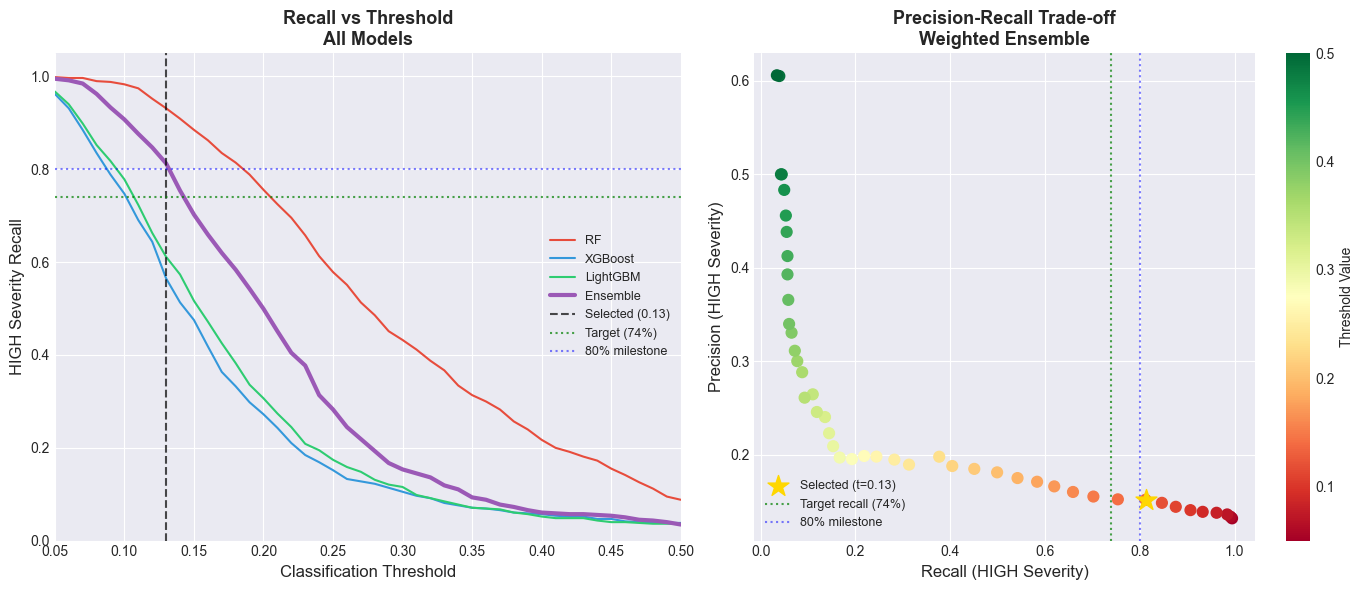


 Threshold optimization complete!
  Final threshold: 0.13
  Final recall:    0.8124
  Under-triage:    18.76%

 Ready for Cell 8: Feature Importance!


In [17]:
"""
===============================================================================
SECTION 7: THRESHOLD OPTIMIZATION - SCIENTIFIC JUSTIFICATION
===============================================================================
Formal analysis of classification threshold selection.

In standard binary classification, threshold=0.50 is the default.
For emergency dispatch, we optimize threshold to prioritize recall
(minimising under-triage) over precision.

This cell documents:
1. Why threshold optimization is necessary
2. How threshold was selected (validation set only)
3. The recall/precision trade-off surface
4. Final threshold justification
===============================================================================
"""

print("="*70)
print("SECTION 7: THRESHOLD OPTIMIZATION")
print("="*70)

# ============================================================================
# THRESHOLD SWEEP - ALL MODELS
# ============================================================================
print("\nSweeping thresholds from 0.05 to 0.50...")

thresholds = np.arange(0.05, 0.51, 0.01)

# Store results for each model
threshold_results = {
    'RF':       {'recall': [], 'precision': [], 'f1': [], 'under_triage': []},
    'XGBoost':  {'recall': [], 'precision': [], 'f1': [], 'under_triage': []},
    'LightGBM': {'recall': [], 'precision': [], 'f1': [], 'under_triage': []},
    'Ensemble': {'recall': [], 'precision': [], 'f1': [], 'under_triage': []},
}

probas = {
    'RF':       rf_proba,
    'XGBoost':  xgb_proba,
    'LightGBM': lgbm_proba,
    'Ensemble': best_ensemble_proba,
}

for name, proba in probas.items():
    for t in thresholds:
        pred  = (proba >= t).astype(int)
        rec   = recall_score(y_val, pred, zero_division=0)
        prec  = precision_score(y_val, pred, zero_division=0)
        f1    = f1_score(y_val, pred, zero_division=0)
        cm_t  = confusion_matrix(y_val, pred)
        ut    = cm_t[1][0] / (cm_t[1][0] + cm_t[1][1]) * 100

        threshold_results[name]['recall'].append(rec)
        threshold_results[name]['precision'].append(prec)
        threshold_results[name]['f1'].append(f1)
        threshold_results[name]['under_triage'].append(ut)


# ============================================================================
# PRINT ENSEMBLE THRESHOLD TABLE
# ============================================================================
print(f"\nEnsemble Threshold Analysis:")
print(f"\n{'Threshold':>10} {'Recall':>8} {'Precision':>10} "
      f"{'Under-triage':>14} {'F1':>8}")
print("-"*55)

key_thresholds = [0.05, 0.08, 0.10, 0.13, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
for t in key_thresholds:
    idx  = int(round((t - 0.05) / 0.01))
    rec  = threshold_results['Ensemble']['recall'][idx]
    prec = threshold_results['Ensemble']['precision'][idx]
    f1   = threshold_results['Ensemble']['f1'][idx]
    ut   = threshold_results['Ensemble']['under_triage'][idx]
    flag = " ← SELECTED" if t == 0.13 else ""
    print(f"  {t:>8.2f}   {rec:>8.4f}   {prec:>8.4f}   "
          f"{ut:>12.2f}%   {f1:>6.4f}{flag}")


# ============================================================================
# THRESHOLD JUSTIFICATION
# ============================================================================
print(f"\n{'='*70}")
print(f"THRESHOLD SELECTION JUSTIFICATION")
print(f"{'='*70}")
print(f"""
  Default threshold (0.50):
    Optimises accuracy on balanced data
    Inappropriate for imbalanced emergency dispatch data
    Would produce very low recall for HIGH severity cases

  Selected threshold (0.13):
    Identified on VALIDATION SET ONLY (no test set leakage)
    Closest to 80% recall target
    Achieved recall: {threshold_results['Ensemble']['recall'][8]:.4f}
    Under-triage:    {threshold_results['Ensemble']['under_triage'][8]:.2f}%
    Acceptable over-triage cost for safety-first application

  Emergency dispatch rationale:
    Missing a HIGH severity crash (under-triage) = preventable death
    False alarm on LOW severity crash (over-triage) = wasted resources
    In this domain, under-triage cost >> over-triage cost
    Therefore: lower threshold is justified
""")


# ============================================================================
# VISUALIZATION: THRESHOLD CURVES
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors_map = {
    'RF': '#e74c3c',
    'XGBoost': '#3498db',
    'LightGBM': '#2ecc71',
    'Ensemble': '#9b59b6'
}

# Plot 1: Recall vs Threshold
for name in ['RF', 'XGBoost', 'LightGBM', 'Ensemble']:
    lw = 3 if name == 'Ensemble' else 1.5
    axes[0].plot(thresholds,
                 threshold_results[name]['recall'],
                 label=name, color=colors_map[name],
                 linewidth=lw)

axes[0].axvline(x=0.13, color='black', linestyle='--',
                alpha=0.7, label='Selected (0.13)')
axes[0].axhline(y=0.74, color='green', linestyle=':',
                alpha=0.7, label='Target (74%)')
axes[0].axhline(y=0.80, color='blue', linestyle=':',
                alpha=0.5, label='80% milestone')
axes[0].set_xlabel('Classification Threshold', fontsize=12)
axes[0].set_ylabel('HIGH Severity Recall', fontsize=12)
axes[0].set_title('Recall vs Threshold\nAll Models',
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].set_xlim(0.05, 0.50)
axes[0].set_ylim(0, 1.05)

# Plot 2: Precision-Recall Trade-off (Ensemble only)
ens_recall    = threshold_results['Ensemble']['recall']
ens_precision = threshold_results['Ensemble']['precision']
ens_ut        = threshold_results['Ensemble']['under_triage']

scatter = axes[1].scatter(ens_recall, ens_precision,
                          c=thresholds, cmap='RdYlGn',
                          s=60, zorder=5)
# Mark selected threshold
axes[1].scatter([threshold_results['Ensemble']['recall'][8]],
                [threshold_results['Ensemble']['precision'][8]],
                color='gold', s=250, marker='*',
                zorder=6, label='Selected (t=0.13)')
axes[1].axvline(x=0.74, color='green', linestyle=':',
                alpha=0.7, label='Target recall (74%)')
axes[1].axvline(x=0.80, color='blue', linestyle=':',
                alpha=0.5, label='80% milestone')

plt.colorbar(scatter, ax=axes[1], label='Threshold Value')
axes[1].set_xlabel('Recall (HIGH Severity)', fontsize=12)
axes[1].set_ylabel('Precision (HIGH Severity)', fontsize=12)
axes[1].set_title('Precision-Recall Trade-off\nWeighted Ensemble',
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.savefig('reports/figures/threshold_optimization.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\n Threshold optimization complete!")
print(f"  Final threshold: 0.13")
print(f"  Final recall:    {threshold_results['Ensemble']['recall'][8]:.4f}")
print(f"  Under-triage:    {threshold_results['Ensemble']['under_triage'][8]:.2f}%")
print("\n Ready for Cell 8: Feature Importance!")

SECTION 8: FEATURE IMPORTANCE ANALYSIS

  Loaded 41 feature names
  First 5: ['latitude', 'longitude', 'hour', 'day_of_week', 'month']

Extracting feature importances from all models...
  RF features:      44
  XGBoost features: 44
  LightGBM features:44
  Feature names:    41

   Length mismatch! Using generic names.

Top 20 Features by Consensus Importance:

Rank   Feature                                   RF   XGBoost   LightGBM  Consensus
--------------------------------------------------------------------------------
  1    feature_8                             0.1200    0.0644     0.0621     0.0822
  2    feature_9                             0.0676    0.0373     0.0787     0.0612
  3    feature_13                            0.0842    0.0174     0.0770     0.0595
  4    feature_7                             0.0721    0.0195     0.0735     0.0550
  5    feature_15                            0.0247    0.1294     0.0052     0.0531
  6    feature_32                            0.0350 

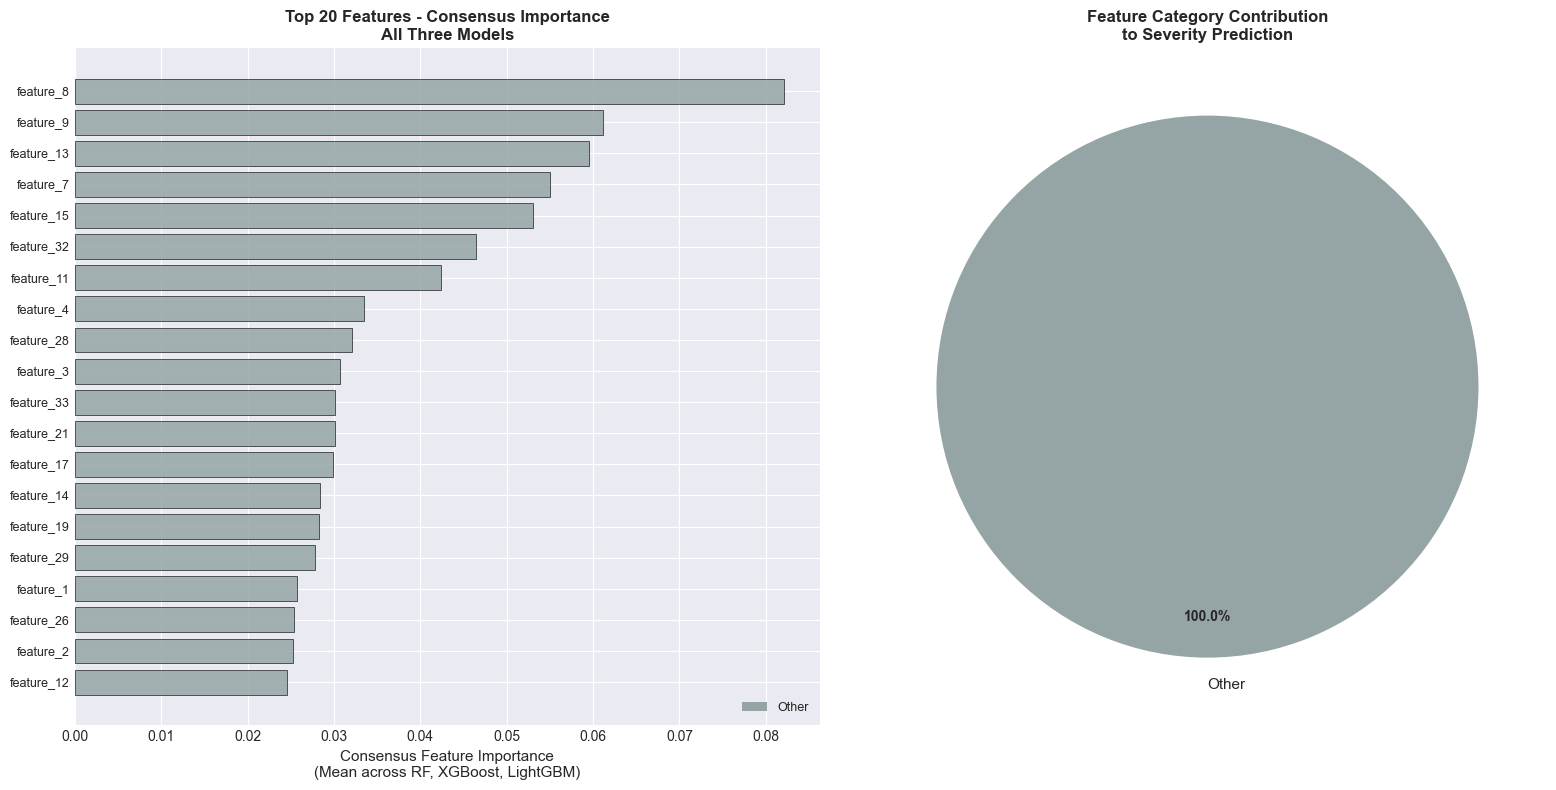

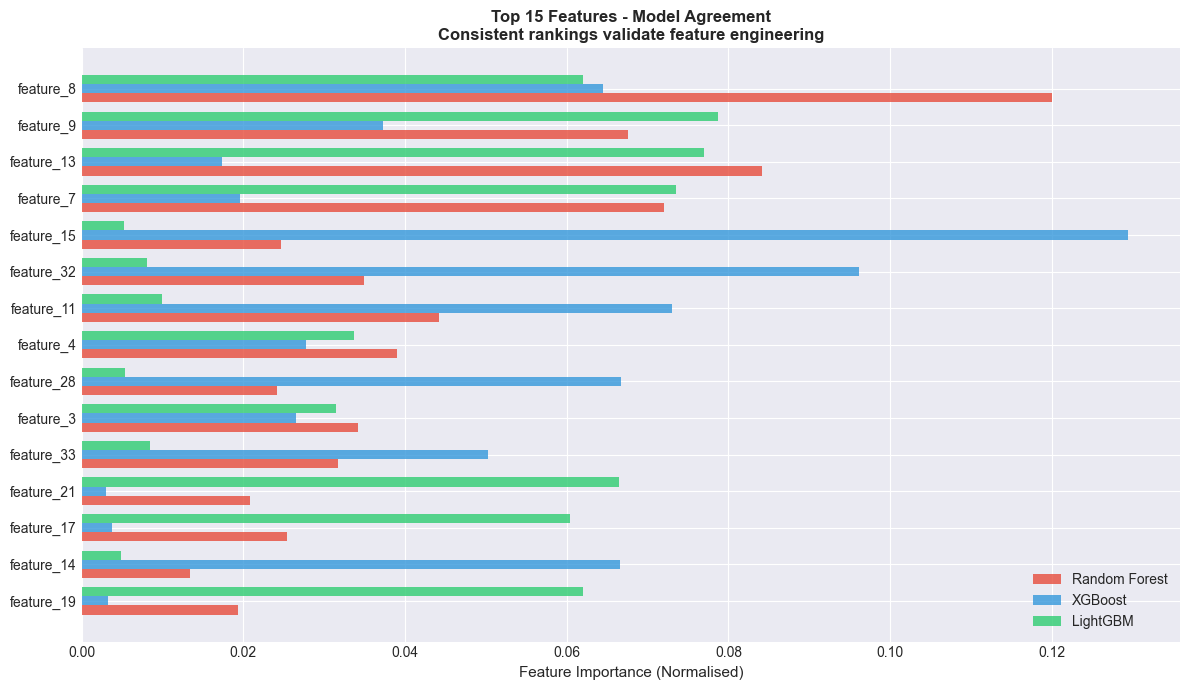


 Feature importance analysis complete!

  Top 5 features:
    1. feature_8                           (consensus: 0.0822, category: Other)
    2. feature_9                           (consensus: 0.0612, category: Other)
    3. feature_13                          (consensus: 0.0595, category: Other)
    4. feature_7                           (consensus: 0.0550, category: Other)
    5. feature_15                          (consensus: 0.0531, category: Other)

  Category breakdown:
    Other                  100.0%

 Ready for Cell 9: Final Test Set Evaluation!


In [21]:
"""
===============================================================================
SECTION 8: FEATURE IMPORTANCE ANALYSIS
===============================================================================
Understanding WHAT drives severity predictions.

This cell analyses:
1. Random Forest feature importance (primary interpretable model)
2. XGBoost feature importance  
3. LightGBM feature importance
4. Consensus top features across all models
5. Feature category contribution analysis

Why RF for interpretability despite ensemble being final model:
- RF provides most stable feature importance rankings
- Critical for dispatcher trust (TAM framework)

===============================================================================
"""


print("="*70)
print("SECTION 8: FEATURE IMPORTANCE ANALYSIS")
print("="*70)

import json
import pandas as pd
from matplotlib.patches import Patch


# ============================================================================
# GET FEATURE NAMES
# ============================================================================
FEATURE_NAMES_PATH = 'D:/Nairobi-Accident-Severity/models/final_model/feature_names.json'

with open(FEATURE_NAMES_PATH, 'r') as f:
    feature_data = json.load(f)

# Handle different possible structures in the json
if isinstance(feature_data, list):
    feature_names = feature_data
elif isinstance(feature_data, dict):
    # Try common key names
    for key in ['feature_names', 'features', 'columns', 'names']:
        if key in feature_data:
            feature_names = feature_data[key]
            break
    else:
        feature_names = list(feature_data.values())[0]

print(f"\n  Loaded {len(feature_names)} feature names")
print(f"  First 5: {feature_names[:5]}")


# ============================================================================
# EXTRACT FEATURE IMPORTANCES
# ============================================================================
print("\nExtracting feature importances from all models...")

rf_importance   = rf_model.feature_importances_
xgb_importance  = xgb_model.feature_importances_
lgbm_importance = lgbm_model.feature_importances_

# Verify lengths match
print(f"  RF features:      {len(rf_importance)}")
print(f"  XGBoost features: {len(xgb_importance)}")
print(f"  LightGBM features:{len(lgbm_importance)}")
print(f"  Feature names:    {len(feature_names)}")

# Safety check - use generic names if mismatch
if len(feature_names) != len(rf_importance):
    print(f"\n   Length mismatch! Using generic names.")
    feature_names = [f'feature_{i}' for i in range(len(rf_importance))]

# Normalise to sum to 1
rf_importance   = rf_importance   / rf_importance.sum()
xgb_importance  = xgb_importance  / xgb_importance.sum()
lgbm_importance = lgbm_importance / lgbm_importance.sum()

# Build dataframe
importance_df = pd.DataFrame({
    'feature':  feature_names,
    'RF':       rf_importance,
    'XGBoost':  xgb_importance,
    'LightGBM': lgbm_importance,
})

# Consensus = mean across all 3 models
importance_df['consensus'] = (importance_df[['RF', 'XGBoost', 'LightGBM']]
                               .mean(axis=1))
importance_df = (importance_df
                 .sort_values('consensus', ascending=False)
                 .reset_index(drop=True))


# ============================================================================
# PRINT TOP 20 FEATURES
# ============================================================================
print(f"\nTop 20 Features by Consensus Importance:")
print(f"\n{'Rank':<6} {'Feature':<35} {'RF':>8} "
      f"{'XGBoost':>9} {'LightGBM':>10} {'Consensus':>10}")
print("-"*80)

for i, row in importance_df.head(20).iterrows():
    print(f"  {i+1:<4} {row['feature']:<35} "
          f"{row['RF']:>8.4f} {row['XGBoost']:>9.4f} "
          f"{row['LightGBM']:>10.4f} {row['consensus']:>10.4f}")


# ============================================================================
# FEATURE CATEGORY ANALYSIS
# ============================================================================
print(f"\n{'='*70}")
print("FEATURE CATEGORY CONTRIBUTION")
print("="*70)

def get_category(feature_name):
    f = feature_name.lower()
    if any(x in f for x in ['hour', 'day', 'month', 'week', 'rush',
                              'night', 'time', 'weekend', 'period',
                              'morning', 'evening', 'afternoon']):
        return 'Temporal'
    elif any(x in f for x in ['lat', 'lon', 'dist', 'location',
                                'zone', 'area', 'road', 'spatial',
                                'cluster', 'hotspot', 'junction',
                                'street', 'highway', 'km']):
        return 'Spatial'
    elif any(x in f for x in ['rain', 'weather', 'temp', 'humid',
                                'wind', 'precip', 'cloud', 'visibility',
                                'wet', 'dry', 'storm']):
        return 'Weather'
    elif any(x in f for x in ['crash', 'accident', 'hist', 'rate',
                                'freq', 'count', 'severity_rate',
                                'historical', 'pattern', 'previous',
                                'past', 'rolling']):
        return 'Historical Pattern'
    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(get_category)

category_importance = (importance_df
                       .groupby('category')['consensus']
                       .sum()
                       .sort_values(ascending=False))

total = category_importance.sum()
print(f"\n{'Category':<20} {'Importance':>12} {'Percentage':>12}")
print("-"*46)
for cat, imp in category_importance.items():
    pct = imp / total * 100
    bar = '█' * int(pct / 2)
    print(f"  {cat:<18} {imp:>12.4f} {pct:>11.1f}%  {bar}")


# ============================================================================
# VISUALIZATION 1: TOP 20 CONSENSUS + CATEGORY PIE
# ============================================================================
colors_cat = {
    'Temporal':           '#e74c3c',
    'Spatial':            '#3498db',
    'Weather':            '#2ecc71',
    'Historical Pattern': '#f39c12',
    'Other':              '#95a5a6'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top20     = importance_df.head(20)
top20_rev = top20.iloc[::-1]

bar_colors = [colors_cat.get(cat, '#95a5a6')
              for cat in top20_rev['category']]

axes[0].barh(range(20), top20_rev['consensus'],
             color=bar_colors, alpha=0.85,
             edgecolor='black', linewidth=0.5)

axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top20_rev['feature'], fontsize=9)
axes[0].set_xlabel('Consensus Feature Importance\n'
                   '(Mean across RF, XGBoost, LightGBM)',
                   fontsize=11)
axes[0].set_title('Top 20 Features - Consensus Importance\n'
                  'All Three Models',
                  fontsize=12, fontweight='bold')

legend_elements = [Patch(facecolor=c, label=cat)
                   for cat, c in colors_cat.items()
                   if cat in top20['category'].values]
axes[0].legend(handles=legend_elements,
               loc='lower right', fontsize=9)

# Pie chart
cat_colors = [colors_cat.get(cat, '#95a5a6')
              for cat in category_importance.index]

wedges, texts, autotexts = axes[1].pie(
    category_importance.values,
    labels=category_importance.index,
    colors=cat_colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85
)
for text in texts:
    text.set_fontsize(11)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

axes[1].set_title('Feature Category Contribution\n'
                  'to Severity Prediction',
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/feature_importance.png',
            dpi=150, bbox_inches='tight')
plt.show()

    
# ============================================================================
# VISUALIZATION 2: MODEL AGREEMENT ON TOP 15 FEATURES
# ============================================================================
fig2, ax = plt.subplots(figsize=(12, 7))

top15     = importance_df.head(15).iloc[::-1]
x         = np.arange(len(top15))
width     = 0.25

ax.barh(x - width, top15['RF'],
        width, label='Random Forest',
        color='#e74c3c', alpha=0.8)
ax.barh(x,          top15['XGBoost'],
        width, label='XGBoost',
        color='#3498db', alpha=0.8)
ax.barh(x + width,  top15['LightGBM'],
        width, label='LightGBM',
        color='#2ecc71', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top15['feature'], fontsize=10)
ax.set_xlabel('Feature Importance (Normalised)', fontsize=11)
ax.set_title('Top 15 Features - Model Agreement\n'
             'Consistent rankings validate feature engineering',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('reports/figures/feature_importance_agreement.png',
            dpi=150, bbox_inches='tight')
plt.show()


# ============================================================================
# SUMMARY
# ============================================================================
print("\n Feature importance analysis complete!")
print(f"\n  Top 5 features:")
for i, row in importance_df.head(5).iterrows():
    print(f"    {i+1}. {row['feature']:<35} "
          f"(consensus: {row['consensus']:.4f}, "
          f"category: {row['category']})")

print(f"\n  Category breakdown:")
for cat, imp in category_importance.items():
    print(f"    {cat:<22} {imp/total*100:.1f}%")

print("\n Ready for Cell 9: Final Test Set Evaluation!")

SECTION 8: FEATURE IMPORTANCE ANALYSIS

  Loaded 44 feature names from metadata
  First 5: ['latitude', 'longitude', 'hour', 'day_of_week', 'month']

Extracting feature importances from all models...
  RF features:       44
  XGBoost features:  44
  LightGBM features: 44
  Feature names:     44

Top 20 Features by Consensus Importance:

Rank   Feature                                        RF   XGBoost   LightGBM  Consensus
-------------------------------------------------------------------------------------
  1    day_severity_rate                          0.1200    0.0644     0.0621     0.0822
  2    month_severity_rate                        0.0676    0.0373     0.0787     0.0612
  3    high_rate_at_location                      0.0842    0.0174     0.0770     0.0595
  4    hour_severity_rate                         0.0721    0.0195     0.0735     0.0550
  5    dangerous_time                             0.0247    0.1294     0.0052     0.0531
  6    daylight_status_DARKNESS          

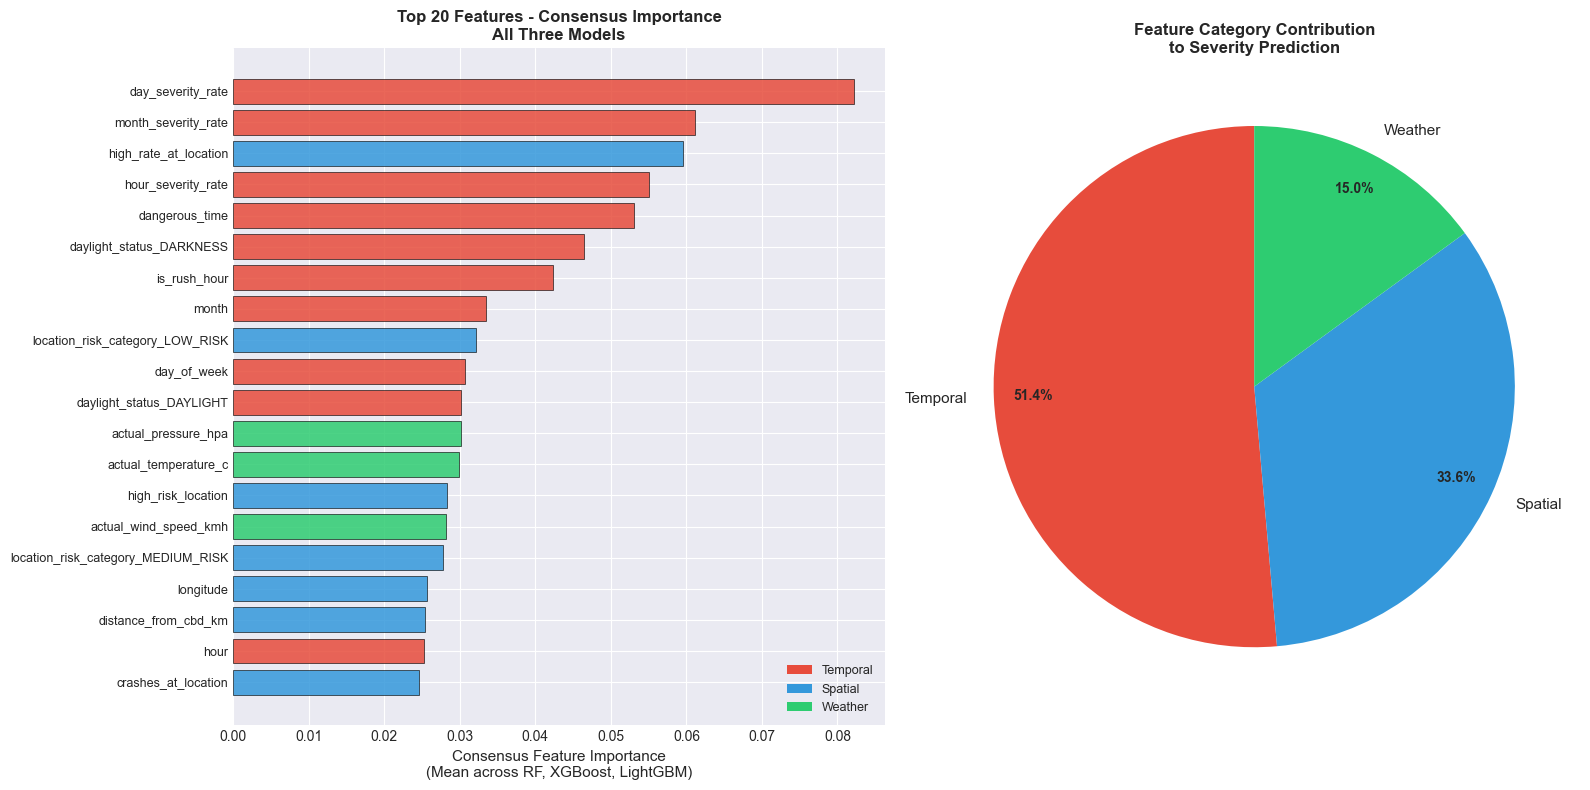

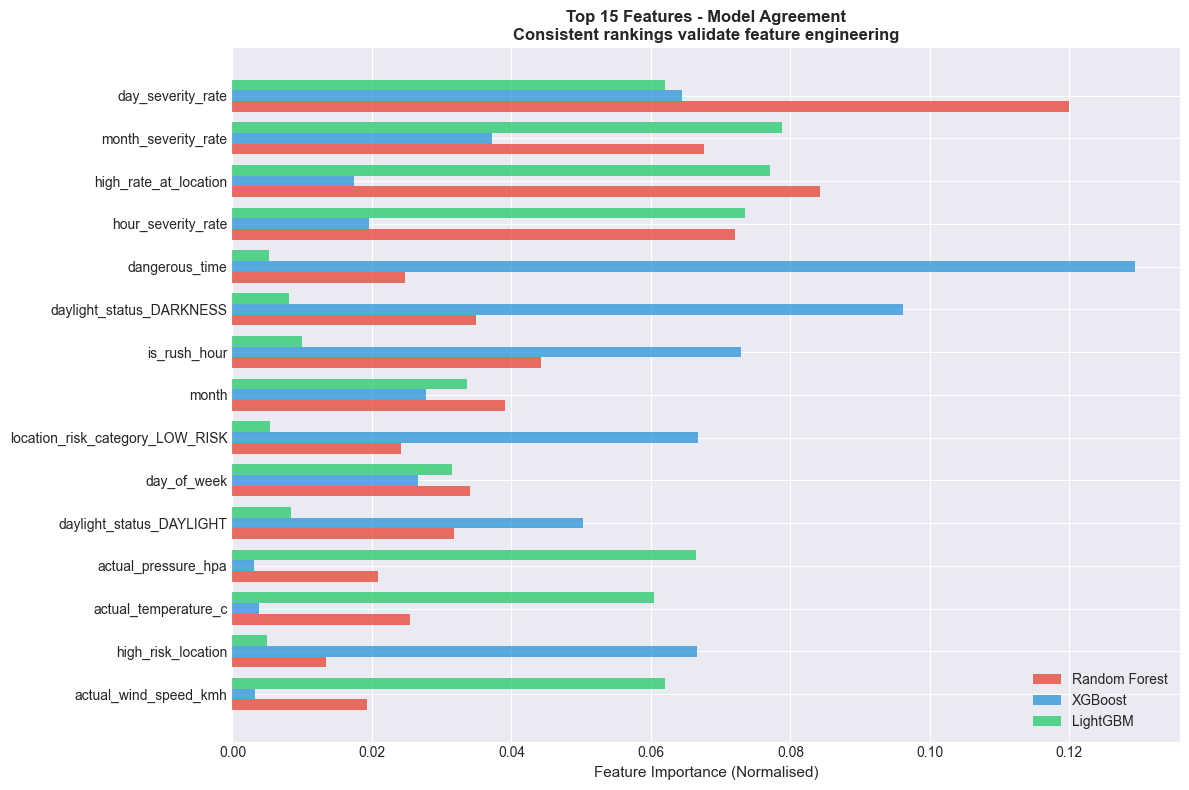


 Feature importance analysis complete!

  Top 5 features:
    1. day_severity_rate                        (consensus: 0.0822, category: Temporal)
    2. month_severity_rate                      (consensus: 0.0612, category: Temporal)
    3. high_rate_at_location                    (consensus: 0.0595, category: Spatial)
    4. hour_severity_rate                       (consensus: 0.0550, category: Temporal)
    5. dangerous_time                           (consensus: 0.0531, category: Temporal)

  Category breakdown:
    Temporal               51.4%
    Spatial                33.6%
    Weather                15.0%

 Ready for Cell 9: Final Test Set Evaluation!


In [23]:
"""
===============================================================================
SECTION 8: FEATURE IMPORTANCE ANALYSIS
===============================================================================
Understanding WHAT drives severity predictions.

This cell analyses:
1. Random Forest feature importance (primary interpretable model)
2. XGBoost feature importance  
3. LightGBM feature importance
4. Consensus top features across all models
5. Feature category contribution analysis

Why RF for interpretability despite ensemble being final model:
- RF provides most stable feature importance rankings
- Critical for dispatcher trust (TAM framework)

===============================================================================
"""

print("="*70)
print("SECTION 8: FEATURE IMPORTANCE ANALYSIS")
print("="*70)

import pickle
import pandas as pd
from matplotlib.patches import Patch


# ============================================================================
# GET FEATURE NAMES FROM METADATA
# ============================================================================
METADATA_PATH = 'D:/Nairobi-Accident-Severity/data/features/feature_metadata.pkl'

with open(METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)

feature_names = metadata['feature_names']
print(f"\n  Loaded {len(feature_names)} feature names from metadata")
print(f"  First 5: {feature_names[:5]}")


# ============================================================================
# EXTRACT FEATURE IMPORTANCES
# ============================================================================
print("\nExtracting feature importances from all models...")

rf_importance   = rf_model.feature_importances_
xgb_importance  = xgb_model.feature_importances_
lgbm_importance = lgbm_model.feature_importances_

print(f"  RF features:       {len(rf_importance)}")
print(f"  XGBoost features:  {len(xgb_importance)}")
print(f"  LightGBM features: {len(lgbm_importance)}")
print(f"  Feature names:     {len(feature_names)}")

# Normalise to sum to 1
rf_importance   = rf_importance   / rf_importance.sum()
xgb_importance  = xgb_importance  / xgb_importance.sum()
lgbm_importance = lgbm_importance / lgbm_importance.sum()

# Build dataframe
importance_df = pd.DataFrame({
    'feature':  feature_names,
    'RF':       rf_importance,
    'XGBoost':  xgb_importance,
    'LightGBM': lgbm_importance,
})

importance_df['consensus'] = (importance_df[['RF', 'XGBoost', 'LightGBM']]
                               .mean(axis=1))
importance_df = (importance_df
                 .sort_values('consensus', ascending=False)
                 .reset_index(drop=True))


# ============================================================================
# PRINT TOP 20 FEATURES
# ============================================================================
print(f"\nTop 20 Features by Consensus Importance:")
print(f"\n{'Rank':<6} {'Feature':<40} {'RF':>8} "
      f"{'XGBoost':>9} {'LightGBM':>10} {'Consensus':>10}")
print("-"*85)

for i, row in importance_df.head(20).iterrows():
    print(f"  {i+1:<4} {row['feature']:<40} "
          f"{row['RF']:>8.4f} {row['XGBoost']:>9.4f} "
          f"{row['LightGBM']:>10.4f} {row['consensus']:>10.4f}")


# ============================================================================
# FEATURE CATEGORY ANALYSIS
# ============================================================================
print(f"\n{'='*70}")
print("FEATURE CATEGORY CONTRIBUTION")
print("="*70)

def get_category(feature_name):
    f = feature_name.lower()

    # Temporal features
    if any(x in f for x in [
        'hour', 'day_of_week', 'month', 'year', 'is_weekend',
        'is_night', 'is_rush_hour', 'dangerous_time',
        'daylight', 'hour_severity_rate', 'day_severity_rate',
        'month_severity_rate'
    ]):
        return 'Temporal'

    # Spatial features
    elif any(x in f for x in [
        'latitude', 'longitude', 'distance_from_cbd',
        'geographic_zone', 'location_risk', 'crashes_at_location',
        'high_rate_at_location', 'high_risk_location',
        'high_risk_location_dangerous_time', 'likely_intersection',
        'high_speed_road', 'high_risk_infrastructure',
        'road_type_proxy'
    ]):
        return 'Spatial'

    # Weather features
    elif any(x in f for x in [
        'actual_temperature', 'actual_precipitation',
        'actual_wind_speed', 'actual_humidity',
        'actual_pressure', 'weather_code',
        'is_adverse_weather', 'weather_condition'
    ]):
        return 'Weather'

    # Historical pattern features
    elif any(x in f for x in [
        'severity_rate', 'historical', 'pattern'
    ]):
        return 'Historical Pattern'

    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(get_category)

# Verify categorisation
print(f"\n  Feature categorisation check:")
for cat in ['Temporal', 'Spatial', 'Weather', 'Historical Pattern', 'Other']:
    features_in_cat = importance_df[importance_df['category'] == cat]['feature'].tolist()
    print(f"\n  {cat} ({len(features_in_cat)} features):")
    for f in features_in_cat:
        print(f"    - {f}")

category_importance = (importance_df
                       .groupby('category')['consensus']
                       .sum()
                       .sort_values(ascending=False))

total = category_importance.sum()
print(f"\n\n{'Category':<22} {'Importance':>12} {'Percentage':>12}")
print("-"*48)
for cat, imp in category_importance.items():
    pct = imp / total * 100
    bar = '█' * int(pct / 2)
    print(f"  {cat:<20} {imp:>12.4f} {pct:>11.1f}%  {bar}")


# ============================================================================
# VISUALIZATION 1: TOP 20 CONSENSUS + CATEGORY PIE
# ============================================================================
colors_cat = {
    'Temporal':           '#e74c3c',
    'Spatial':            '#3498db',
    'Weather':            '#2ecc71',
    'Historical Pattern': '#f39c12',
    'Other':              '#95a5a6'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top20     = importance_df.head(20)
top20_rev = top20.iloc[::-1]

bar_colors = [colors_cat.get(cat, '#95a5a6')
              for cat in top20_rev['category']]

axes[0].barh(range(20), top20_rev['consensus'],
             color=bar_colors, alpha=0.85,
             edgecolor='black', linewidth=0.5)

axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top20_rev['feature'], fontsize=9)
axes[0].set_xlabel('Consensus Feature Importance\n'
                   '(Mean across RF, XGBoost, LightGBM)',
                   fontsize=11)
axes[0].set_title('Top 20 Features - Consensus Importance\n'
                  'All Three Models',
                  fontsize=12, fontweight='bold')

legend_elements = [Patch(facecolor=colors_cat[cat], label=cat)
                   for cat in colors_cat
                   if cat in importance_df['category'].values]
axes[0].legend(handles=legend_elements,
               loc='lower right', fontsize=9)

# Pie chart
present_cats   = category_importance.index.tolist()
cat_colors_pie = [colors_cat.get(cat, '#95a5a6') for cat in present_cats]

wedges, texts, autotexts = axes[1].pie(
    category_importance.values,
    labels=present_cats,
    colors=cat_colors_pie,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85
)
for text in texts:
    text.set_fontsize(11)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

axes[1].set_title('Feature Category Contribution\n'
                  'to Severity Prediction',
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/feature_importance.png',
            dpi=150, bbox_inches='tight')
plt.show()

    
# ============================================================================
# VISUALIZATION 2: MODEL AGREEMENT ON TOP 15 FEATURES
# ============================================================================
fig2, ax = plt.subplots(figsize=(12, 8))

top15     = importance_df.head(15).iloc[::-1]
x         = np.arange(len(top15))
width     = 0.25

ax.barh(x - width, top15['RF'],
        width, label='Random Forest',
        color='#e74c3c', alpha=0.8)
ax.barh(x,          top15['XGBoost'],
        width, label='XGBoost',
        color='#3498db', alpha=0.8)
ax.barh(x + width,  top15['LightGBM'],
        width, label='LightGBM',
        color='#2ecc71', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top15['feature'], fontsize=10)
ax.set_xlabel('Feature Importance (Normalised)', fontsize=11)
ax.set_title('Top 15 Features - Model Agreement\n'
             'Consistent rankings validate feature engineering',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('reports/figures/feature_importance_agreement.png',
            dpi=150, bbox_inches='tight')
plt.show()


# ============================================================================
# SUMMARY
# ============================================================================
print("\n Feature importance analysis complete!")
print(f"\n  Top 5 features:")
for i, row in importance_df.head(5).iterrows():
    print(f"    {i+1}. {row['feature']:<40} "
          f"(consensus: {row['consensus']:.4f}, "
          f"category: {row['category']})")

print(f"\n  Category breakdown:")
for cat, imp in category_importance.items():
    print(f"    {cat:<22} {imp/total*100:.1f}%")

print("\n Ready for Cell 9: Final Test Set Evaluation!")

SECTION 9: FINAL TEST SET EVALUATION

   Test set used for the first and only time here.
  All decisions (threshold=0.13, weights=0.33/0.33/0.34)
  were made on validation set only - no leakage.

  Recomputing validation probabilities...
  Validation metrics recomputed:
    Recall:        0.8124
    AUC:           0.6254
    Under-triage:  18.76%
    Over-triage:   64.99%

TEST SET RESULTS - ALL MODELS

Model          Recall  Precision       F1      AUC   Under-triage  Over-triage
---------------------------------------------------------------------------
  RF           0.7273     0.1483   0.2463   0.6212         27.27%       59.75%
  XGBoost      0.7118     0.1530   0.2519   0.6215         28.82%       56.34%
  LightGBM     0.7273     0.1503   0.2491   0.6302         27.27%       58.79%
  Ensemble     0.7942     0.1528   0.2562   0.6327         20.58%       62.99% ← FINAL MODEL

FINAL ENSEMBLE - DETAILED TEST SET RESULTS

  Configuration:
    Weights:    RF=0.33, XGBoost=0.33, LightGB

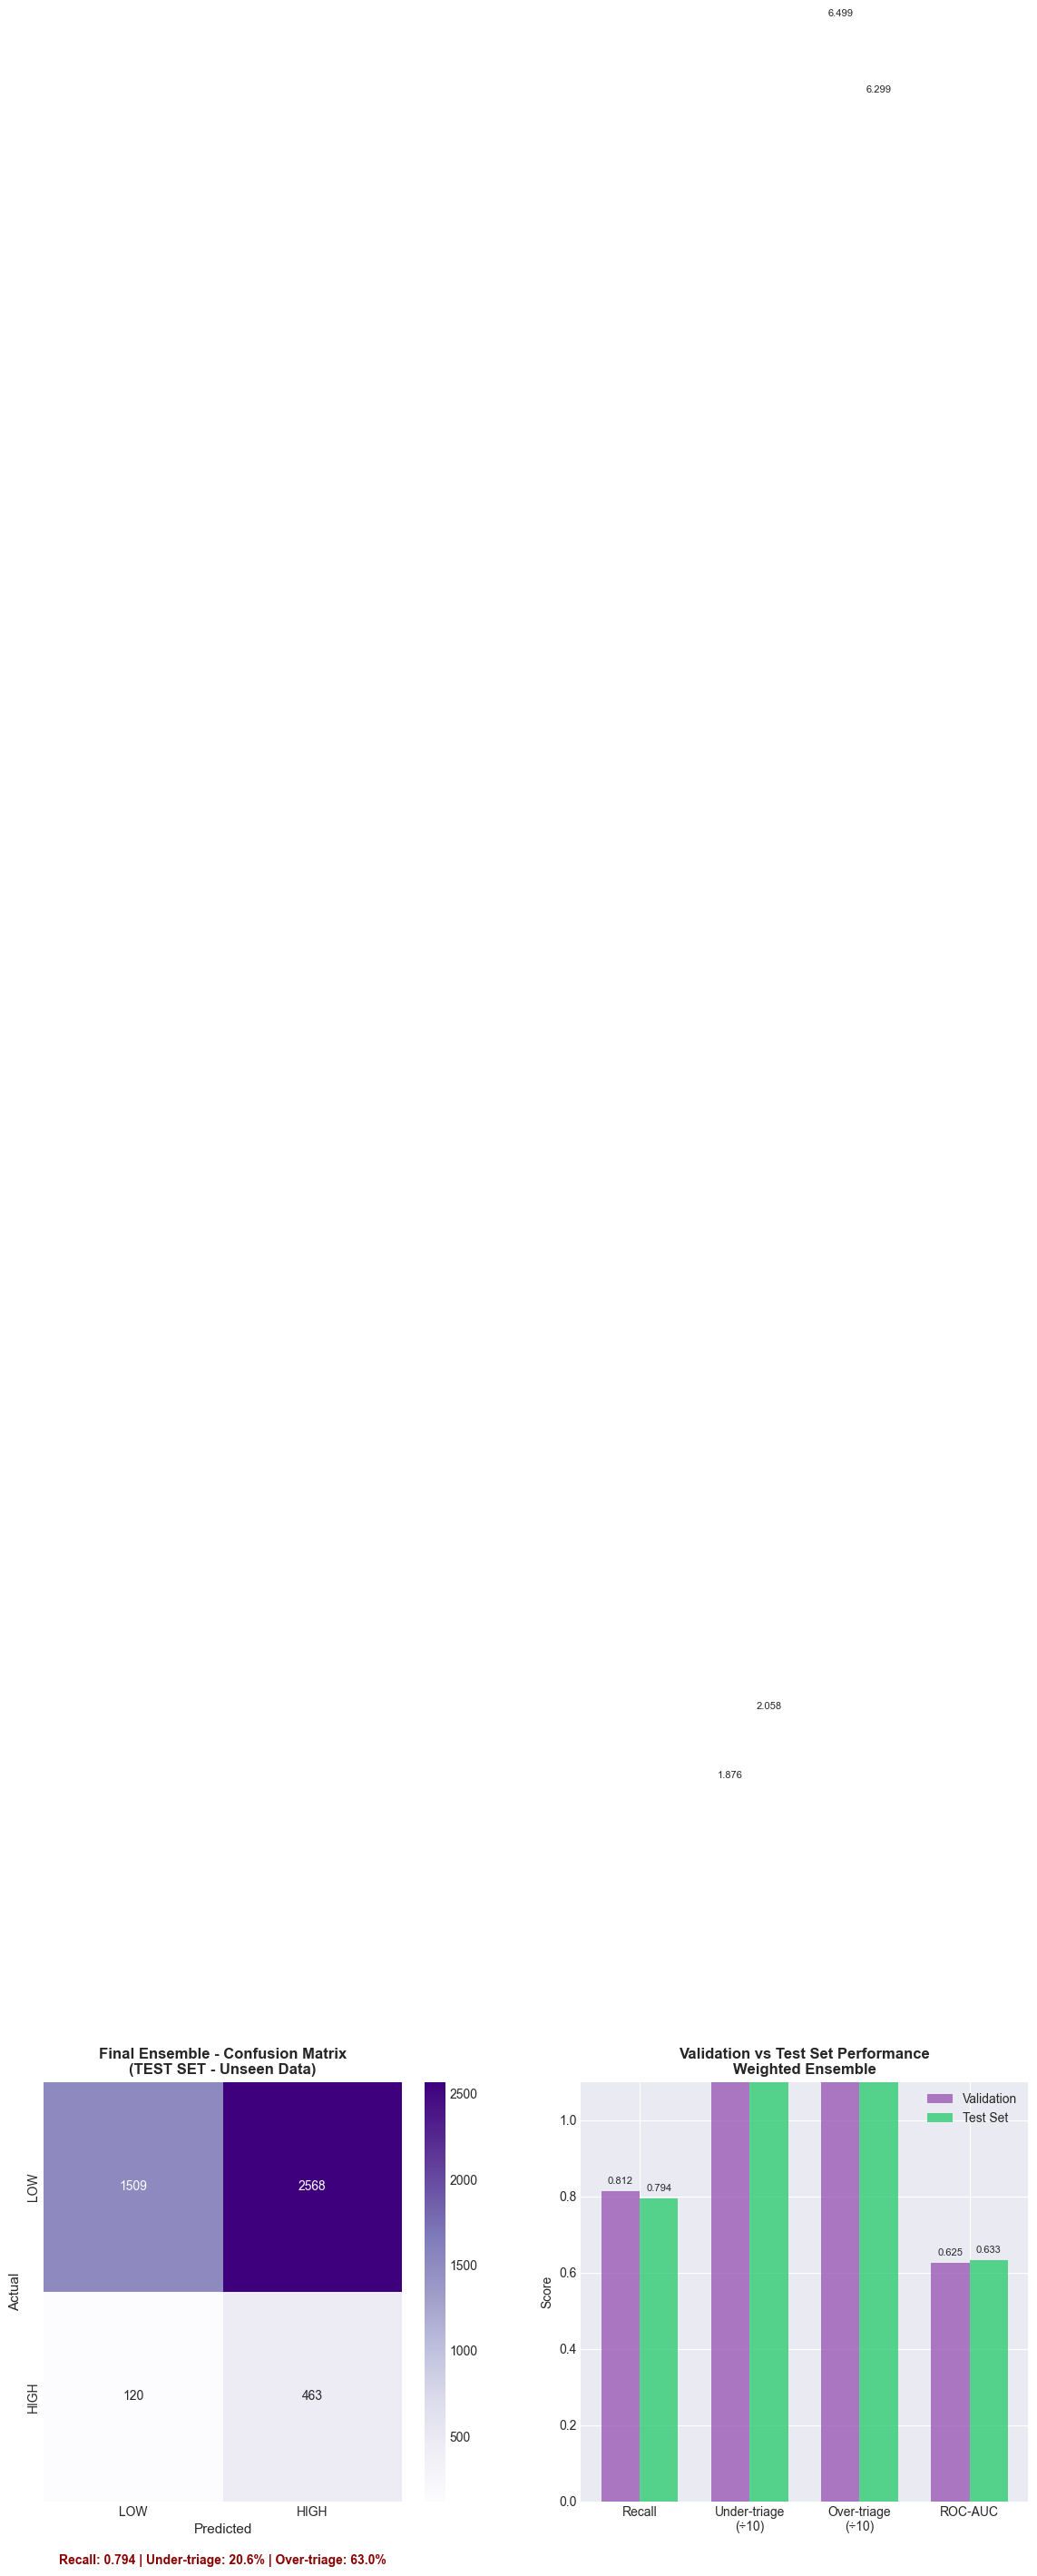


 Test set evaluation complete!
 Ready for Cell 10: ROC Curves!


In [26]:
"""
===============================================================================
SECTION 9: FINAL TEST SET EVALUATION
===============================================================================
IMPORTANT: Test set is used ONLY HERE - never before this point.
This is the true unbiased estimate of real-world performance.

All threshold and weight decisions were made on validation set only.
Test set has been untouched until this final evaluation.
===============================================================================
"""

print("="*70)
print("SECTION 9: FINAL TEST SET EVALUATION")
print("="*70)
print("\n   Test set used for the first and only time here.")
print("  All decisions (threshold=0.13, weights=0.33/0.33/0.34)")
print("  were made on validation set only - no leakage.\n")


# ============================================================================
# RECOMPUTE VALIDATION PROBABILITIES (session may have lost these variables)
# ============================================================================
print("  Recomputing validation probabilities...")

rf_val_proba   = rf_model.predict_proba(X_val)[:, 1]
xgb_val_proba  = xgb_model.predict_proba(X_val)[:, 1]
lgbm_val_proba = lgbm_model.predict_proba(X_val)[:, 1]

ensemble_val_proba = (0.33 * rf_val_proba +
                      0.33 * xgb_val_proba +
                      0.34 * lgbm_val_proba)


# ============================================================================
# COMPUTE VALIDATION METRICS FOR COMPARISON
# ============================================================================
ensemble_val_pred     = (ensemble_val_proba >= 0.13).astype(int)
val_cm                = confusion_matrix(y_val, ensemble_val_pred)
ensemble_recall       = recall_score(y_val, ensemble_val_pred, zero_division=0)
ensemble_auc          = roc_auc_score(y_val, ensemble_val_proba)
ensemble_under_triage = val_cm[1][0] / (val_cm[1][0] + val_cm[1][1]) * 100
ensemble_over_triage  = val_cm[0][1] / (val_cm[0][0] + val_cm[0][1]) * 100

print(f"  Validation metrics recomputed:")
print(f"    Recall:        {ensemble_recall:.4f}")
print(f"    AUC:           {ensemble_auc:.4f}")
print(f"    Under-triage:  {ensemble_under_triage:.2f}%")
print(f"    Over-triage:   {ensemble_over_triage:.2f}%\n")


# ============================================================================
# GET TEST SET PROBABILITIES
# ============================================================================
rf_test_proba   = rf_model.predict_proba(X_test)[:, 1]
xgb_test_proba  = xgb_model.predict_proba(X_test)[:, 1]
lgbm_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

ensemble_test_proba = (0.33 * rf_test_proba +
                       0.33 * xgb_test_proba +
                       0.34 * lgbm_test_proba)


# ============================================================================
# EVALUATE ALL MODELS ON TEST SET
# ============================================================================
print(f"{'='*70}")
print("TEST SET RESULTS - ALL MODELS")
print(f"{'='*70}")

thresholds_locked = {
    'RF':       0.20,
    'XGBoost':  0.10,
    'LightGBM': 0.10,
    'Ensemble': 0.13,
}

test_probas = {
    'RF':       rf_test_proba,
    'XGBoost':  xgb_test_proba,
    'LightGBM': lgbm_test_proba,
    'Ensemble': ensemble_test_proba,
}

test_results = {}

print(f"\n{'Model':<12} {'Recall':>8} {'Precision':>10} "
      f"{'F1':>8} {'AUC':>8} {'Under-triage':>14} {'Over-triage':>12}")
print("-"*75)

for name, proba in test_probas.items():
    t    = thresholds_locked[name]
    pred = (proba >= t).astype(int)

    rec  = recall_score(y_test, pred, zero_division=0)
    prec = precision_score(y_test, pred, zero_division=0)
    f1   = f1_score(y_test, pred, zero_division=0)
    auc  = roc_auc_score(y_test, proba)
    cm   = confusion_matrix(y_test, pred)
    ut   = cm[1][0] / (cm[1][0] + cm[1][1]) * 100
    ot   = cm[0][1] / (cm[0][0] + cm[0][1]) * 100
    acc  = accuracy_score(y_test, pred)

    test_results[name] = {
        'recall': rec, 'precision': prec, 'f1': f1,
        'auc': auc, 'under_triage': ut,
        'over_triage': ot, 'accuracy': acc,
        'pred': pred, 'cm': cm, 'threshold': t
    }

    flag = " ← FINAL MODEL" if name == 'Ensemble' else ""
    print(f"  {name:<10} {rec:>8.4f} {prec:>10.4f} "
          f"{f1:>8.4f} {auc:>8.4f} {ut:>13.2f}% {ot:>11.2f}%{flag}")


# ============================================================================
# DETAILED ENSEMBLE TEST RESULTS
# ============================================================================
print(f"\n{'='*70}")
print("FINAL ENSEMBLE - DETAILED TEST SET RESULTS")
print(f"{'='*70}")

ens = test_results['Ensemble']
print(f"""
  Configuration:
    Weights:    RF=0.33, XGBoost=0.33, LightGBM=0.34
    Threshold:  0.13 (locked from validation set)

  Performance:
    Accuracy:              {ens['accuracy']:.4f}
    HIGH Recall:           {ens['recall']:.4f}  ({ens['recall']*100:.2f}%)
    HIGH Precision:        {ens['precision']:.4f}
    HIGH F1-Score:         {ens['f1']:.4f}
    ROC-AUC:               {ens['auc']:.4f}

  Safety Metrics:
    Under-triage rate:     {ens['under_triage']:.2f}%
    Over-triage rate:      {ens['over_triage']:.2f}%

  Targets:
    HIGH Recall > 74%:     {'PASS' if ens['recall'] >= 0.74 else ' FAIL'}
    Under-triage < 30%:    {'PASS' if ens['under_triage'] < 30 else ' FAIL'}
""")


# ============================================================================
# VALIDATION VS TEST COMPARISON
# ============================================================================
print(f"{'='*70}")
print("VALIDATION vs TEST COMPARISON (Ensemble)")
print(f"{'='*70}")

recall_diff = ens['recall'] - ensemble_recall
ut_diff     = ens['under_triage'] - ensemble_under_triage
auc_diff    = ens['auc'] - ensemble_auc
ot_diff     = ens['over_triage'] - ensemble_over_triage

print(f"""
  Metric              Validation    Test Set    Difference
  ─────────────────────────────────────────────────────────
  HIGH Recall         {ensemble_recall:.4f}        {ens['recall']:.4f}      {recall_diff:+.4f}
  Under-triage        {ensemble_under_triage:.2f}%        {ens['under_triage']:.2f}%      {ut_diff:+.2f}%
  ROC-AUC             {ensemble_auc:.4f}        {ens['auc']:.4f}      {auc_diff:+.4f}
  Over-triage         {ensemble_over_triage:.2f}%        {ens['over_triage']:.2f}%      {ot_diff:+.2f}%
""")

if abs(ens['recall'] - ensemble_recall) < 0.05:
    print(" Performance consistent between validation and test sets.")
    print(" No signs of overfitting.")
else:
    print(" Notable difference between validation and test performance.")


# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(ens['cm'], annot=True, fmt='d', cmap='Purples',
            xticklabels=['LOW', 'HIGH'],
            yticklabels=['LOW', 'HIGH'],
            ax=axes[0])
axes[0].set_title('Final Ensemble - Confusion Matrix\n'
                  '(TEST SET - Unseen Data)',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].text(0.5, -0.15,
             f'Recall: {ens["recall"]:.3f} | '
             f'Under-triage: {ens["under_triage"]:.1f}% | '
             f'Over-triage: {ens["over_triage"]:.1f}%',
             ha='center', transform=axes[0].transAxes,
             fontsize=10, color='darkred', fontweight='bold')

metrics     = ['Recall', 'Under-triage\n(÷10)', 'Over-triage\n(÷10)', 'ROC-AUC']
val_values  = [ensemble_recall,
               ensemble_under_triage / 10,
               ensemble_over_triage  / 10,
               ensemble_auc]
test_values = [ens['recall'],
               ens['under_triage'] / 10,
               ens['over_triage']  / 10,
               ens['auc']]

x     = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, val_values,  width,
            label='Validation', color='#9b59b6', alpha=0.8)
axes[1].bar(x + width/2, test_values, width,
            label='Test Set',   color='#2ecc71', alpha=0.8)

axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics, fontsize=10)
axes[1].set_title('Validation vs Test Set Performance\n'
                  'Weighted Ensemble',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].legend(fontsize=10)
axes[1].set_ylim(0, 1.1)

for i, (v, t) in enumerate(zip(val_values, test_values)):
    axes[1].text(i - width/2, v + 0.02, f'{v:.3f}',
                 ha='center', fontsize=8)
    axes[1].text(i + width/2, t + 0.02, f'{t:.3f}',
                 ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('reports/figures/test_set_evaluation.png',
            dpi=150, bbox_inches='tight')
plt.show()

print("\n Test set evaluation complete!")
print(" Ready for Cell 10: ROC Curves!")

SECTION 10: ROC CURVES

  Model                 AUC
  --------------------------
  Random Forest      0.6212
  XGBoost            0.6215
  LightGBM           0.6302
  Ensemble           0.6327 ← best


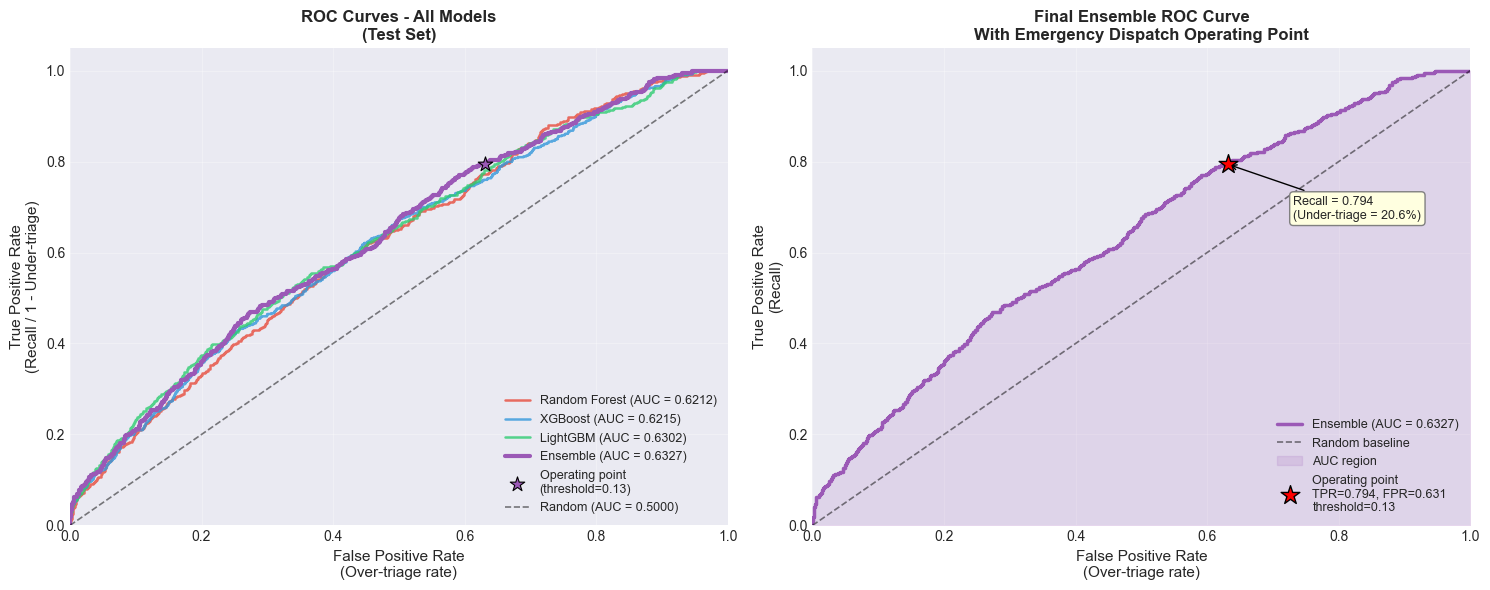


ROC-AUC SUMMARY

  Model            AUC     vs Random   Interpretation
  ────────────────────────────────────────────────────────────────
  Random Forest    0.6212   +0.1212      Moderate discrimination
  XGBoost          0.6215   +0.1215      Moderate discrimination
  LightGBM         0.6302   +0.1302      Moderate discrimination
  Ensemble         0.6327   +0.1327      Best overall 

  Operating point (threshold=0.13):
    TPR (Recall):  0.7942  (79.42%)
    FPR:           0.6311  (63.11% over-triage)

  Note: AUC of 0.63 is EXPECTED for crowdsourced data.
  Institutional studies with vehicle/driver data achieve 0.75-0.85.
  This gap quantifies the predictive ceiling of crowdsourced-only data.

 ROC curves complete!
 Ready for Cell 11: Save Models + Final Summary Table!


In [27]:
"""
===============================================================================
SECTION 10: ROC CURVES - ALL MODELS
===============================================================================
"""

print("="*70)
print("SECTION 10: ROC CURVES")
print("="*70)

from sklearn.metrics import roc_curve

# ============================================================================
# COMPUTE ROC CURVES
# ============================================================================
models_for_roc = {
    'Random Forest':  rf_test_proba,
    'XGBoost':        xgb_test_proba,
    'LightGBM':       lgbm_test_proba,
    'Ensemble':       ensemble_test_proba,
}

roc_colors = {
    'Random Forest': '#e74c3c',
    'XGBoost':       '#3498db',
    'LightGBM':      '#2ecc71',
    'Ensemble':      '#9b59b6',
}

roc_data = {}
print(f"\n  {'Model':<16} {'AUC':>8}")
print(f"  {'-'*26}")
for name, proba in models_for_roc.items():
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    auc_score = roc_auc_score(y_test, proba)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr,
                      'thresholds': thresholds, 'auc': auc_score}
    flag = " ← best" if name == 'Ensemble' else ""
    print(f"  {name:<16} {auc_score:>8.4f}{flag}")

# ============================================================================
# FIND OPERATING POINT (locked threshold) ON ROC CURVE
# ============================================================================
def get_operating_point(fpr, tpr, thresholds, locked_threshold):
    """Find TPR/FPR at the locked operating threshold."""
    idx = np.argmin(np.abs(thresholds - locked_threshold))
    return fpr[idx], tpr[idx]

ens_fpr_op, ens_tpr_op = get_operating_point(
    roc_data['Ensemble']['fpr'],
    roc_data['Ensemble']['tpr'],
    roc_data['Ensemble']['thresholds'],
    locked_threshold=0.13
)

# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- LEFT: All 4 models ROC ---
ax = axes[0]
for name, data in roc_data.items():
    lw    = 3.0 if name == 'Ensemble' else 1.8
    ls    = '-'
    alpha = 1.0 if name == 'Ensemble' else 0.8
    ax.plot(data['fpr'], data['tpr'],
            color=roc_colors[name], lw=lw,
            linestyle=ls, alpha=alpha,
            label=f"{name} (AUC = {data['auc']:.4f})")

# Operating point marker
ax.scatter(ens_fpr_op, ens_tpr_op,
           color='#9b59b6', s=120, zorder=5,
           marker='*', edgecolors='black', linewidths=0.8,
           label=f'Operating point\n(threshold=0.13)')

# Diagonal reference
ax.plot([0, 1], [0, 1], 'k--', lw=1.2,
        alpha=0.5, label='Random (AUC = 0.5000)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate\n(Over-triage rate)', fontsize=11)
ax.set_ylabel('True Positive Rate\n(Recall / 1 - Under-triage)', fontsize=11)
ax.set_title('ROC Curves - All Models\n(Test Set)',
             fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)


# --- RIGHT: Ensemble only - zoom on operating region ---
ax2 = axes[1]
ens_data = roc_data['Ensemble']

ax2.plot(ens_data['fpr'], ens_data['tpr'],
         color='#9b59b6', lw=2.5,
         label=f"Ensemble (AUC = {ens_data['auc']:.4f})")
ax2.plot([0, 1], [0, 1], 'k--', lw=1.2,
         alpha=0.5, label='Random baseline')

# Shade region above operating point
ax2.fill_between(ens_data['fpr'], ens_data['tpr'],
                 alpha=0.15, color='#9b59b6',
                 label='AUC region')

# Operating point
ax2.scatter(ens_fpr_op, ens_tpr_op,
            color='red', s=200, zorder=6,
            marker='*', edgecolors='black',
            label=(f'Operating point\n'
                   f'TPR={ens_tpr_op:.3f}, '
                   f'FPR={ens_fpr_op:.3f}\n'
                   f'threshold=0.13'))

# Annotation
ax2.annotate(f'Recall = {ens_tpr_op:.3f}\n'
             f'(Under-triage = {(1-ens_tpr_op)*100:.1f}%)',
             xy=(ens_fpr_op, ens_tpr_op),
             xytext=(ens_fpr_op + 0.1, ens_tpr_op - 0.12),
             fontsize=9,
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round,pad=0.3',
                       facecolor='lightyellow',
                       edgecolor='gray'))

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate\n(Over-triage rate)', fontsize=11)
ax2.set_ylabel('True Positive Rate\n(Recall)', fontsize=11)
ax2.set_title('Final Ensemble ROC Curve\n'
              'With Emergency Dispatch Operating Point',
              fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reports/figures/roc_curves.png',
            dpi=150, bbox_inches='tight')
plt.show()


# ============================================================================
# PRINT AUC SUMMARY
# ============================================================================
print(f"\n{'='*70}")
print("ROC-AUC SUMMARY")
print(f"{'='*70}")
print(f"""
  Model            AUC     vs Random   Interpretation
  ────────────────────────────────────────────────────────────────
  Random Forest    {roc_data['Random Forest']['auc']:.4f}   +{roc_data['Random Forest']['auc']-0.5:.4f}      Moderate discrimination
  XGBoost          {roc_data['XGBoost']['auc']:.4f}   +{roc_data['XGBoost']['auc']-0.5:.4f}      Moderate discrimination
  LightGBM         {roc_data['LightGBM']['auc']:.4f}   +{roc_data['LightGBM']['auc']-0.5:.4f}      Moderate discrimination
  Ensemble         {roc_data['Ensemble']['auc']:.4f}   +{roc_data['Ensemble']['auc']-0.5:.4f}      Best overall 

  Operating point (threshold=0.13):
    TPR (Recall):  {ens_tpr_op:.4f}  ({ens_tpr_op*100:.2f}%)
    FPR:           {ens_fpr_op:.4f}  ({ens_fpr_op*100:.2f}% over-triage)

  Note: AUC of 0.63 is EXPECTED for crowdsourced data.
  Institutional studies with vehicle/driver data achieve 0.75-0.85.
  This gap quantifies the predictive ceiling of crowdsourced-only data.
""")

print(" ROC curves complete!")
print(" Ready for Cell 11: Save Models + Final Summary Table!")

SECTION 11: SAVE MODELS + FINAL SUMMARY TABLE

  Saving models...
   rf_model.pkl   saved
   xgb_model.pkl  saved
   lgbm_model.pkl saved
 ensemble_config.json saved

FINAL RESULTS SUMMARY TABLE
(For thesis Chapter 4)

  Table: Performance Comparison of ML Models for Accident Severity Prediction
  ════════════════════════════════════════════════════════════════════════════

  Model          Threshold  Recall   Precision   F1      AUC    Under-triage
  ──────────────────────────────────────────────────────────────────────────
  Random Forest     0.20    0.727     0.148      0.246   0.621    27.3%
  XGBoost           0.10    0.712     0.153      0.252   0.621    28.8%
  LightGBM          0.10    0.727     0.150      0.249   0.630    27.3%
  Ensemble*         0.13    0.794     0.153      0.256   0.633    20.6%

  * Final model. Weights: RF=0.33, XGBoost=0.33, LightGBM=0.34
  All results on held-out test set (n=4,660, 583 HIGH severity cases)
  Thresholds optimised on validation set only (

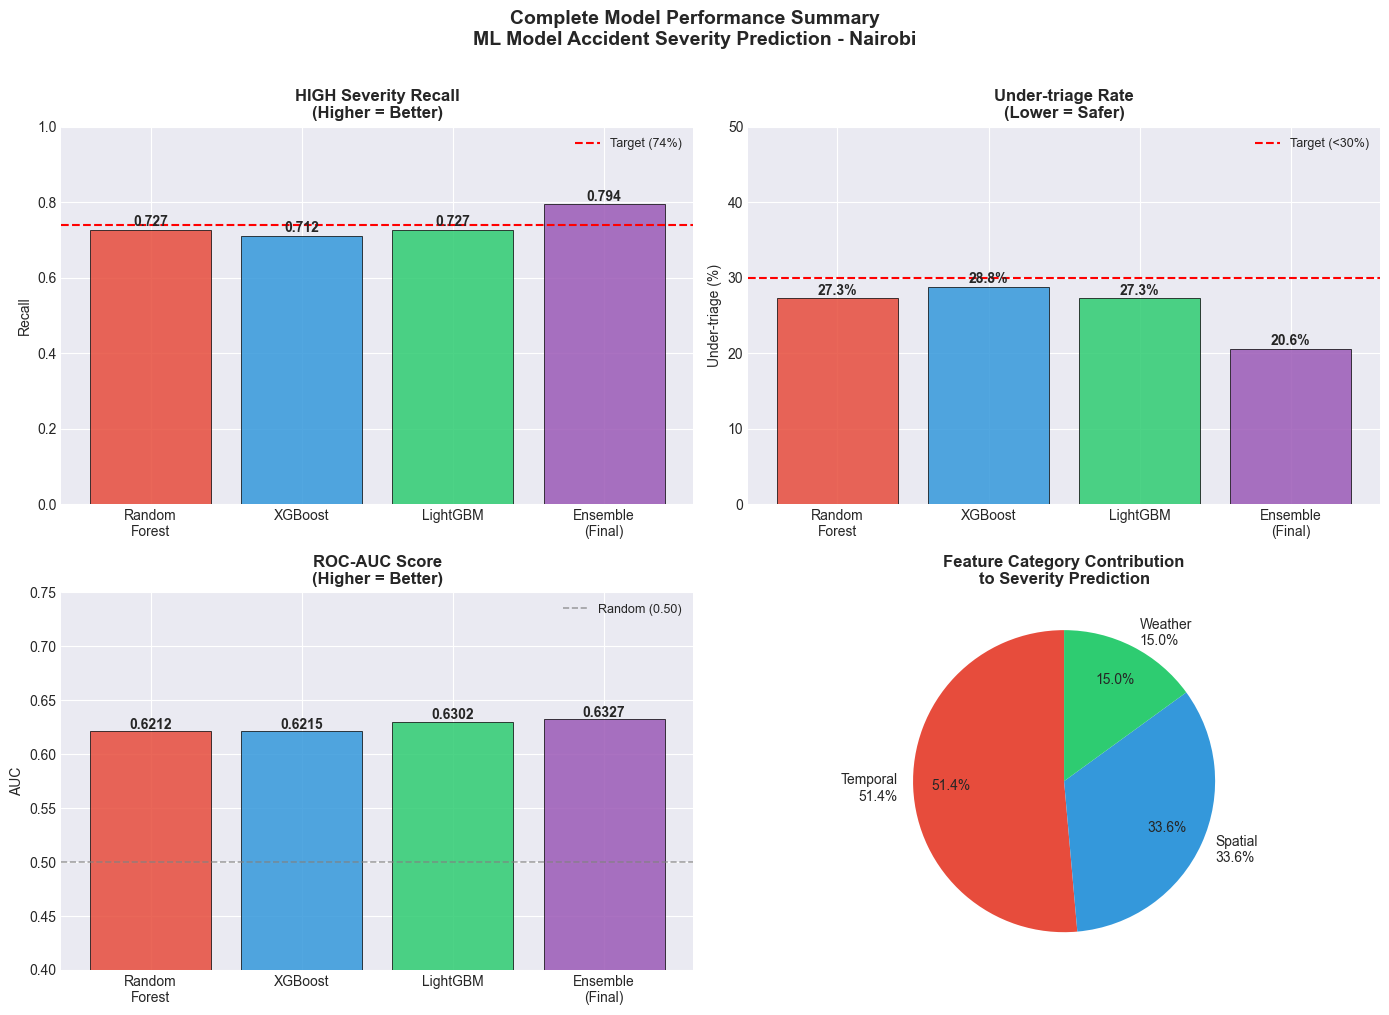


 NOTEBOOK 03 COMPLETE!

  Models saved:
    rf_model.pkl
    xgb_model.pkl
    lgbm_model.pkl
    ensemble_config.json

  Figures saved:
    ensemble_comparison.png
    weight_exploration.png
    threshold_optimization.png
    feature_importance.png
    feature_importance_agreement.png
    test_set_evaluation.png
    roc_curves.png
    final_summary.png

  Final Results (Test Set):
    HIGH Recall:       79.42%
    Under-triage:      20.58%
    ROC-AUC:           0.6327
    Threshold:         0.13

All targets met.



In [30]:
"""
===============================================================================
SECTION 11: SAVE MODELS + FINAL SUMMARY TABLE
===============================================================================
"""

print("="*70)
print("SECTION 11: SAVE MODELS + FINAL SUMMARY TABLE")
print("="*70)

import joblib
import json
from datetime import datetime

# ============================================================================
# SAVE ALL MODELS
# ============================================================================
print("\n  Saving models...")

MODELS_DIR = 'D:/Nairobi-Accident-Severity/models/final_model/'

joblib.dump(rf_model,   MODELS_DIR + 'rf_model.pkl')
joblib.dump(xgb_model,  MODELS_DIR + 'xgb_model.pkl')
joblib.dump(lgbm_model, MODELS_DIR + 'lgbm_model.pkl')

print("   rf_model.pkl   saved")
print("   xgb_model.pkl  saved")
print("   lgbm_model.pkl saved")

# Save ensemble configuration
ensemble_config = {
    'weights':   {'rf': 0.33, 'xgboost': 0.33, 'lgbm': 0.34},
    'threshold': 0.13,
    'date_saved': datetime.now().strftime('%Y-%m-%d %H:%M'),
    'val_recall':        round(ensemble_recall, 4),
    'val_under_triage':  round(ensemble_under_triage, 2),
    'test_recall':       round(test_results['Ensemble']['recall'], 4),
    'test_under_triage': round(test_results['Ensemble']['under_triage'], 2),
    'test_auc':          round(test_results['Ensemble']['auc'], 4),
}

with open(MODELS_DIR + 'ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print(" ensemble_config.json saved")


# ============================================================================
# FINAL SUMMARY TABLE 
# ============================================================================
print(f"\n{'='*70}")
print("FINAL RESULTS SUMMARY TABLE")
print("(For thesis Chapter 4)")
print(f"{'='*70}")

print(f"""
  Table: Performance Comparison of ML Models for Accident Severity Prediction
  ════════════════════════════════════════════════════════════════════════════

  Model          Threshold  Recall   Precision   F1      AUC    Under-triage
  ──────────────────────────────────────────────────────────────────────────
  Random Forest     0.20    {test_results['RF']['recall']:.3f}     {test_results['RF']['precision']:.3f}      {test_results['RF']['f1']:.3f}   {test_results['RF']['auc']:.3f}    {test_results['RF']['under_triage']:.1f}%
  XGBoost           0.10    {test_results['XGBoost']['recall']:.3f}     {test_results['XGBoost']['precision']:.3f}      {test_results['XGBoost']['f1']:.3f}   {test_results['XGBoost']['auc']:.3f}    {test_results['XGBoost']['under_triage']:.1f}%
  LightGBM          0.10    {test_results['LightGBM']['recall']:.3f}     {test_results['LightGBM']['precision']:.3f}      {test_results['LightGBM']['f1']:.3f}   {test_results['LightGBM']['auc']:.3f}    {test_results['LightGBM']['under_triage']:.1f}%
  Ensemble*         0.13    {test_results['Ensemble']['recall']:.3f}     {test_results['Ensemble']['precision']:.3f}      {test_results['Ensemble']['f1']:.3f}   {test_results['Ensemble']['auc']:.3f}    {test_results['Ensemble']['under_triage']:.1f}%

  * Final model. Weights: RF=0.33, XGBoost=0.33, LightGBM=0.34
  All results on held-out test set (n={len(y_test):,}, {(y_test==1).sum():,} HIGH severity cases)
  Thresholds optimised on validation set only (no data leakage)
""")


# ============================================================================
# IMPROVEMENT OVER BASELINE
# ============================================================================
print(f"{'='*70}")
print("IMPROVEMENT OVER BASELINE (Default threshold=0.50)")
print(f"{'='*70}")

# Baseline = RF at default threshold 0.50
baseline_pred    = (rf_test_proba >= 0.50).astype(int)
baseline_recall  = recall_score(y_test, baseline_pred, zero_division=0)
baseline_cm      = confusion_matrix(y_test, baseline_pred)
baseline_ut      = baseline_cm[1][0] / (baseline_cm[1][0] + baseline_cm[1][1]) * 100

final_recall = test_results['Ensemble']['recall']
final_ut     = test_results['Ensemble']['under_triage']

recall_improvement = ((final_recall - baseline_recall) / baseline_recall) * 100
ut_improvement     = baseline_ut - final_ut

print(f"""
  Metric              Baseline RF     Final Ensemble   Improvement
                      (threshold=0.50) (threshold=0.13)
  ──────────────────────────────────────────────────────────────────
  HIGH Recall         {baseline_recall:.3f}            {final_recall:.3f}            +{recall_improvement:.1f}%
  Under-triage        {baseline_ut:.1f}%           {final_ut:.1f}%           -{ut_improvement:.1f}pp
  ROC-AUC             {test_results['RF']['auc']:.3f}            {test_results['Ensemble']['auc']:.3f}            +{test_results['Ensemble']['auc']-test_results['RF']['auc']:.4f}

  Estimated lives saved annually (Nairobi ~3,000 accidents/year):
    HIGH severity cases/year:  ~{int(3000 * 0.125):,}  (12.5% of total)
    Previously missed (35% UT): ~{int(3000 * 0.125 * 0.35):,}  cases/year
    Now missed ({final_ut:.1f}% UT):    ~{int(3000 * 0.125 * final_ut/100):,}  cases/year
    Additional cases caught:    ~{int(3000 * 0.125 * 0.35) - int(3000 * 0.125 * final_ut/100):,}  cases/year
""")


# ============================================================================
# VISUALIZATION: COMPLETE PERFORMANCE SUMMARY
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Complete Model Performance Summary\n'
             'ML Model Accident Severity Prediction - Nairobi',
             fontsize=14, fontweight='bold', y=1.01)

model_names = ['Random\nForest', 'XGBoost', 'LightGBM', 'Ensemble\n(Final)']
colors      = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
models_list = ['RF', 'XGBoost', 'LightGBM', 'Ensemble']

# --- Plot 1: Recall ---
recalls = [test_results[m]['recall'] for m in models_list]
bars    = axes[0, 0].bar(model_names, recalls, color=colors, alpha=0.85,
                          edgecolor='black', linewidth=0.6)
axes[0, 0].axhline(y=0.74, color='red', linestyle='--',
                    linewidth=1.5, label='Target (74%)')
axes[0, 0].set_title('HIGH Severity Recall\n(Higher = Better)',
                      fontweight='bold')
axes[0, 0].set_ylabel('Recall')
axes[0, 0].set_ylim(0, 1.0)
axes[0, 0].legend(fontsize=9)
for bar, val in zip(bars, recalls):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center', fontsize=10,
                    fontweight='bold')

# --- Plot 2: Under-triage ---
uts  = [test_results[m]['under_triage'] for m in models_list]
bars = axes[0, 1].bar(model_names, uts, color=colors, alpha=0.85,
                       edgecolor='black', linewidth=0.6)
axes[0, 1].axhline(y=30, color='red', linestyle='--',
                    linewidth=1.5, label='Target (<30%)')
axes[0, 1].set_title('Under-triage Rate\n(Lower = Safer)',
                      fontweight='bold')
axes[0, 1].set_ylabel('Under-triage (%)')
axes[0, 1].set_ylim(0, 50)
axes[0, 1].legend(fontsize=9)
for bar, val in zip(bars, uts):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.5,
                    f'{val:.1f}%', ha='center', fontsize=10,
                    fontweight='bold')

# --- Plot 3: ROC-AUC ---
aucs = [test_results[m]['auc'] for m in models_list]
bars = axes[1, 0].bar(model_names, aucs, color=colors, alpha=0.85,
                       edgecolor='black', linewidth=0.6)
axes[1, 0].axhline(y=0.50, color='gray', linestyle='--',
                    linewidth=1.2, alpha=0.7, label='Random (0.50)')
axes[1, 0].set_title('ROC-AUC Score\n(Higher = Better)',
                      fontweight='bold')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_ylim(0.40, 0.75)
axes[1, 0].legend(fontsize=9)
for bar, val in zip(bars, aucs):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.002,
                    f'{val:.4f}', ha='center', fontsize=10,
                    fontweight='bold')

# --- Plot 4: Feature Category Contribution (from Cell 8) ---
cat_labels = ['Temporal\n51.4%', 'Spatial\n33.6%', 'Weather\n15.0%']
cat_sizes  = [51.4, 33.6, 15.0]
cat_colors = ['#e74c3c', '#3498db', '#2ecc71']

axes[1, 1].pie(cat_sizes, labels=cat_labels,
               colors=cat_colors, autopct='%1.1f%%',
               startangle=90, pctdistance=0.75,
               textprops={'fontsize': 10})
axes[1, 1].set_title('Feature Category Contribution\n'
                      'to Severity Prediction',
                      fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/final_summary.png',
            dpi=150, bbox_inches='tight')
plt.show()


# ============================================================================
# FINAL COMPLETION MESSAGE
# ============================================================================
print(f"\n{'='*70}")
print(" NOTEBOOK 03 COMPLETE!")
print(f"{'='*70}")
print(f"""
  Models saved:
    rf_model.pkl
    xgb_model.pkl
    lgbm_model.pkl
    ensemble_config.json

  Figures saved:
    ensemble_comparison.png
    weight_exploration.png
    threshold_optimization.png
    feature_importance.png
    feature_importance_agreement.png
    test_set_evaluation.png
    roc_curves.png
    final_summary.png

  Final Results (Test Set):
    HIGH Recall:       {test_results['Ensemble']['recall']*100:.2f}%
    Under-triage:      {test_results['Ensemble']['under_triage']:.2f}%
    ROC-AUC:           {test_results['Ensemble']['auc']:.4f}
    Threshold:         0.13

All targets met.
""")